## COMP5625M Assessment 1 - Image Classification [100 marks]

<div class="logos"><img src="https://drive.google.com/uc?id=132BXgkV5w1bpXlVpdr5BtZdpagqYvna7" width="220px" align="right"></div>

The maximum number of marks for each part are shown in the section headers. As indicated in the main heading above, the overall assessment carries a maximum of 100 marks.

This summative assessment is weighted 25% of the final grade for the module.

### Motivation 

Through this assessment, you will gain practical experience in:

> 1. Implementing and evaluating a multi-layer perceptron (MLP) and convolutional neural network (CNN) in solving a classification problem
> 2. Building, evaluating, and finetuning a CNN on an image dataset from development to testing 
> 3. Tackling overfitting using strategies such as data augmentation and drop out
> 4. Fine tuning a model 
> 5. Comparing the performance of a new model with an off-the-shelf model (AlexNet)
> 6. Gaining a deeper understanding of model performance using visualisations from Grad-CAM.


### Setup and resources 

You must work using this template notebook.

Having a GPU will speed up the training process. See the provided document on Minerva about setting up a working environment for various ways to access a GPU. We highly recommend you use platforms such as Colab.

Please implement the coursework using **Python and PyTorch**, and refer to the notebooks and exercises provided.

This coursework will use a subset of images from Tiny ImageNet, which is a subset of the [ImageNet dataset](https://www.image-net.org/update-mar-11-2021.php). Our subset of Tiny ImageNet contains **30 different categories**, we will refer to it as TinyImageNet30. The training set has 450 resized images (64x64 pixels) for each category (13,500 images in total). You can download the training and test set from a direct link or the Kaggle challenge website:

>[Direct access to data is possible by clicking here, please use your university email to access this](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/ESF87mN6kelIkjdISkaRow8BublW27jB-P8eWV6Rr4rxtw?e=SPASDB)

>[Access data through Kaggle webpage](https://www.kaggle.com/t/917fe52f6a3c4855880a24b34f26db07) 


### Required submissions

##### 1. Kaggle Competition
To participate in the submission of test results, you will need an account. Even if you have an existing Kaggle account, please carefully adhere to these instructions, or we may not be able to locate your entries:

> 1. Use your **university email** to register a new account.
> 2. Set your **Kaggle account NAME** to your university username, for example, ``sc15jb``.

The class Kaggle competition also includes a blind test set, which will be used in Question 1 for evaluating your custom model's performance on a test set. The competition website will compute the test set accuracy, as well as position your model on the class leaderboard. [Link to submit your results on Kaggle competition](https://www.kaggle.com/competitions/comp5623m-artificial-intelligence/submissions). 

Please submit only your predictions from test set - detailed instructions are provided in (3)

##### 2. Submission of your work

Please submit the following:

> 1. Your completed Jupyter notebook file, without removing anything in the template, in **.ipynb format.**
> 2. The **.html version** of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) displayed in the .html for marking.
> 3. Your selected images from section 6 "Failure/success analysis" (outputs from gradcam, for example you can put these images into failure and succcess folders).

**Final note:**

> **Please display everything that you would like to be marked. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.



Your student username (for example, ```sc15jb```):

--> mm22mkm

Your full name:

--> Mani Krishna Mandepudi

## Required packages

[1] [numpy](http://www.numpy.org) is a package for scientific computing with python

[2] [h5py](http://www.h5py.org) is a package to interact with compactly stored dataset

[3] [matplotlib](http://matplotlib.org) can be used for plotting graphs in python

[4] [pytorch](https://pytorch.org/docs/stable/index.html) is a library widely used for bulding deep-learning frameworks

Feel free to add to this section as needed - examples of importing libraries are provided below.

You may need to install these packages using [pip](https://pypi.org/project/opencv-python/) or [conda](https://anaconda.org/conda-forge/opencv).

In [6]:
import math
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader,Dataset
from torch.hub import load_state_dict_from_url
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn.metrics import confusion_matrix, roc_curve, auc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [78]:
# always check your version
print(torch.__version__)

1.13.0


One challenge of building a deep learning model is to choose an architecture that can learn the features in the dataset without being unnecessarily complex. The first part of the coursework involves building a CNN and training it on TinyImageNet30. 

### **Overview:**

**1. Function implementation** (12 marks)

*   **1.1** PyTorch ```Dataset``` and ```DataLoader``` classes (4 marks)
*   **1.2** PyTorch ```Model``` class for a simple MLP model (4 marks)
*   **1.3** PyTorch ```Model``` class for a simple CNN model (4 marks)

**2. Model training** (20 marks)
*   **2.1** Train on TinyImageNet30 dataset (7 marks)
*   **2.2** Generate confusion matrices and ROC curves (4 marks)
*   **2.3** Strategies for tackling overfitting (9 marks)
    *   **2.3.1** Data augmentation
    *   **2.3.2** Dropout
    *   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)
            

**3. Model Fine-tuning on CIFAR10 dataset** (20 marks)
*   **3.1** Fine-tune your model (initialise your model with pretrained weights from (2)) (8 marks)
*   **3.2** Fine-tune model with frozen base convolution layers (8 marks)
*   **3.3** Compare complete model retraining with pretrained weights and with frozen layers. Comment on what you observe? (4 marks) 

**4. Model testing** (18 marks)
*   **4.1**   Test your final model in (2) on test set - code to do this (10 marks)
*   **4.2**   Upload your result to Kaggle  (8 marks)

**5. Model comparison** (14 marks)
*   **5.1**   Load pretrained AlexNet and finetune on TinyImageNet30 until model convergence (6 marks)
*   **5.2**   Compare the results of your CNN model with pretrained AlexNet on the same validation set. Provide performance values (loss graph, confusion matrix, top-1 accuracy, execution time) (8 marks)

**6. Interpretation of results** (16 marks)
*   **6.1** Use grad-CAM on your model and on AlexNet (6 marks)
*   **6.2** Visualise and compare the results from your model and from AlexNet (4 marks)
*   **6.3** Comment on (6 marks):
    - why the network predictions were correct or not correct in your predictions? 
    - what can you do to improve your results further?

## 1 Function implementations [12 marks]


### 1.1 Dataset class [4 marks]

Write a PyTorch ```Dataset``` class (an example [here](https://www.askpython.com/python-modules/pytorch-custom-datasets) for reference) which loads the TinyImage30 dataset and ```DataLoaders``` for training and validation sets.

In [7]:
# Class for loading datasets
class CustomImageDataset(torch.utils.data.Dataset):
    
    # Initialize the dataset with image directory and transform
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_names = sorted(os.listdir(root_dir))
        self.class_to_idx = {class_name: i for i, class_name in enumerate(self.class_names)}
        self.images = []
        self.labels = []
        for class_name in self.class_names:
            class_dir = os.path.join(root_dir, class_name)
            for filename in os.listdir(class_dir):
                if filename.endswith('.JPEG'):
                    self.images.append(os.path.join(class_dir, filename))
                    self.labels.append(self.class_to_idx[class_name])

    # This function returns the number of samples in the dataset.   
    def __len__(self):
        return len(self.images)
    
    # This function returns the image and the label index.
    def __getitem__(self, index):
        image_path = self.images[index]
        label = self.labels[index]
        image = torchvision.datasets.folder.default_loader(image_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [8]:
def dataloading(transform):
    # Load the dataset of images and apply the transformation
    dataset = CustomImageDataset(root_dir='/kaggle/input/train-dataset/train_set/train_set')
    
    valid_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    # Set the random seed for reproducibility
    torch.manual_seed(0)
    torch.cuda.manual_seed_all(0)
    
    # Splitting the dataset for validation and training in an 80:20 ratio     
    training_size = int(0.8 * len(dataset))
    validation_size = len(dataset) - training_size
    training_dataset, validation_dataset = torch.utils.data.random_split(dataset, [training_size, validation_size])
    
    training_dataset.dataset.transform = transform
    validation_dataset.dataset.transform = valid_transform

    # Create a DataLoader for the training set and validation set
    training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=16, num_workers=2, shuffle=True, generator=torch.Generator().manual_seed(0))
    validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=16, num_workers=2, shuffle=False)

    # Get the class names (labels) corresponding to the subfolders in the dataset
    class_names = dataset.class_names
    
    # Return the datasets and dataloaders for training and validation, along with the class names
    return training_dataset, validation_dataset, training_dataloader, validation_dataloader, class_names


In [9]:
# Define the image preprocessing steps
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load the training and validation datasets, and create dataloaders for them
training_dataset, validation_dataset, training_dataloader, validation_dataloader, class_names = dataloading(train_transform)

#### Display function of training dataset

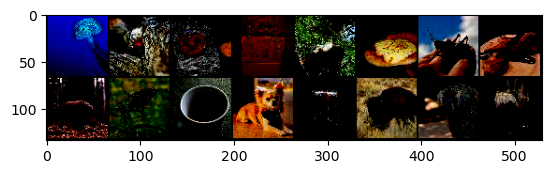

labels ['jellyfish', 'ladybug', 'pretzel', 'refrigerator', 'redpanda', 'pizza', 'grasshopper', 'pretzel', 'pig', 'butterfly', 'espresso', 'chihuahua', 'jellyfish', 'bison', 'baboon', 'pig']


In [10]:
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.show()
     
data_iter = iter(training_dataloader)
images, labels = next(data_iter)

# show images and labels
timshow(torchvision.utils.make_grid(images))
print(f"labels {[class_names[labels[i]] for i in range(16)]}")

#### Display function of validation dataset

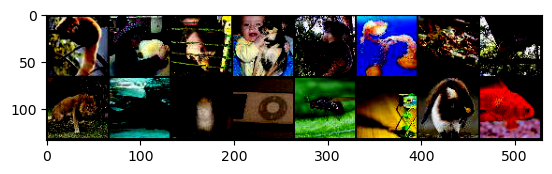

labels ['redpanda', 'sombrero', 'pig', 'chihuahua', 'koala', 'jellyfish', 'pizza', 'koala', 'lion', 'penguin', 'penguin', 'ipod', 'fly', 'hourglass', 'penguin', 'goldfish']


In [11]:
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.show()
     
data_iter = iter(validation_dataloader)
images, labels = next(data_iter)

# show images and labels
timshow(torchvision.utils.make_grid(images))
print(f"labels {[class_names[labels[i]] for i in range(16)]}")

### 1.2 Define a MLP model class [4 marks]

<u>Create a new model class using a combination of:</u>
- Input Units
- Hidden Units
- Output Units
- Activation functions
- Loss function
- Optimiser

In [12]:
class MLP(nn.Module):
    
    # Constructor to initialize the MLP layers
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(MLP, self).__init__()
        
        # Defining three fully connected layers with given input, output sizes
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        
        # Adding ReLU activation function
        self.relu = nn.ReLU()  
    
    # Defining the forward pass of the model
    def forward(self, x):
        out = x.reshape(x.shape[0],-1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out
    
    # This function returns the optimizer function for the model
    def optimizer_function(self, learning_rate):
        return torch.optim.SGD(self.parameters(), lr=learning_rate, momentum = 0.9)
    
    # This function returns the loss function for the model
    def loss_function(self):
        return nn.CrossEntropyLoss() 

In [13]:
# prints an instance of the MLP class 
model = MLP(64 * 64 * 3, 1024, 512, 30)
print(model)

# prints number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

MLP(
  (fc1): Linear(in_features=12288, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=30, bias=True)
  (relu): ReLU()
)
Total parameters: 13124126


### 1.3 Define a CNN model class [4 marks]

<u>Create a new model class using a combination of:</u>
- Convolution layers
- Activation functions (e.g. ReLU)
- Maxpooling layers
- Fully connected layers 
- Loss function
- Optimiser

In [14]:
class CNN(nn.Module):
    
    # Constructor to initialize the CNN layers
    def __init__(self,input_size, num_classes):
        super(CNN, self).__init__()
        
        # Defining the four Convolutional layer and Batch normalization layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) 
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        # Adding max pooling layer with kernel size 2x2         
        self.pool = nn.MaxPool2d(2)
        
        # Defining two fully connected layers with given input, output sizes
        self.fc1 = nn.Linear(128 * input_size, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        
    # Defining the forward pass of the model
    def forward(self, x):
        out = self.pool(torch.relu(self.bn1(self.conv1(x))))
        out = self.pool(torch.relu(self.bn2(self.conv2(out))))
        out = self.pool(torch.relu(self.bn3(self.conv3(out))))
        out = torch.relu(self.bn4(self.conv4(out)))
        out = out.reshape(out.shape[0],-1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

    # This function returns the optimizer function for the model
    def loss_function(self):
        return nn.CrossEntropyLoss()
    
    # This function returns the loss function for the model
    def optimizer_function(self, learning_rate):
        return torch.optim.SGD(self.parameters(), lr=learning_rate, momentum = 0.9)

In [15]:
# prints an instance of the MLP class 
model = CNN(8 * 8, 30)
print(model)

# prints number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=30, bias=True)
)
Total parameters: 8518302


## 2 Model training [20 marks]


### 2.1 Train both MLP and CNN models - show loss and accuracy graphs side by side [7 marks]

Train your model on the TinyImageNet30 dataset. Split the data into train and validation sets to determine when to stop training. Use seed at 0 for reproducibility and test_ratio=0.2 (validation data)

Display the graph of training and validation loss over epochs and accuracy over epochs to show how you determined the optimal number of training epochs. Top-*k* accuracy implementation is provided for you below.

> Please leave the graph clearly displayed. Please use the same graph to plot graphs for both train and validation.


In [16]:
# For both validation and training data, this function will plot the graph for accuracy and loss.
# This function will read data from the csv file that we previously saved after running the model.

def plotgraph(filename, num_epochs):
    
    data = pd.read_csv(filename)
    x = np.arange(num_epochs)
    
    fig, ax = plt.subplots(1, 2, figsize=(10,5))

    ax[0].plot(x, data['Training Accuracy'], label='Training')
    ax[0].plot(x, data['Validation Accuracy'], label='Validation')
    ax[0].set_title('Accuracy Graph')
    ax[0].set_xlabel('No. of epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(x, data['Training Loss'], label='Training')
    ax[1].plot(x, data['Validation Loss'], label='Validation')
    ax[1].set_title('Loss Graph')
    ax[1].set_xlabel('No. of epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    
    plt.show()

In [17]:
# Define top-*k* accuracy 
def topk_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

#### Train and Validate functions

In [18]:
# This training function will train the model with training dataset and 
# returns the training loss and accuracy after evaluation of the model
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0
    train_topk_accuracy = 0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_topk_accuracy += topk_accuracy(outputs, targets)[0].item()
    
    train_loss = train_loss / len(train_loader)
    train_acc = train_topk_accuracy / len(train_loader)
    
    return train_loss, train_acc

# This training function will evaluate the model with training dataset and 
# returns the training loss and accuracy after validation of the model
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    valid_topk_accuracy = 0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            val_loss += loss.item()
            valid_topk_accuracy += topk_accuracy(outputs, targets)[0].item()
            
        val_loss = val_loss / len(val_loader)
        val_acc = valid_topk_accuracy / len(val_loader)
        
    return val_loss, val_acc

#### MLP Model

Epoch: 1/25 Train Loss: 3.1661, Train Accuracy: 11.92%, Validation Loss: 2.9560, Validation Accuracy: 16.14% 
Epoch: 2/25 Train Loss: 2.8386, Train Accuracy: 19.42%, Validation Loss: 2.8024, Validation Accuracy: 19.61% 
Epoch: 3/25 Train Loss: 2.6663, Train Accuracy: 23.86%, Validation Loss: 2.7191, Validation Accuracy: 21.87% 
Epoch: 4/25 Train Loss: 2.5203, Train Accuracy: 27.76%, Validation Loss: 2.6914, Validation Accuracy: 22.53% 
Epoch: 5/25 Train Loss: 2.3642, Train Accuracy: 32.84%, Validation Loss: 2.6929, Validation Accuracy: 23.37% 
Epoch: 6/25 Train Loss: 2.1980, Train Accuracy: 37.82%, Validation Loss: 2.6847, Validation Accuracy: 23.53% 
Epoch: 7/25 Train Loss: 2.0100, Train Accuracy: 43.70%, Validation Loss: 2.7274, Validation Accuracy: 23.90% 
Epoch: 8/25 Train Loss: 1.7933, Train Accuracy: 50.16%, Validation Loss: 2.8460, Validation Accuracy: 23.34% 
Epoch: 9/25 Train Loss: 1.5623, Train Accuracy: 57.64%, Validation Loss: 2.8631, Validation Accuracy: 23.31% 
Epoch: 10/

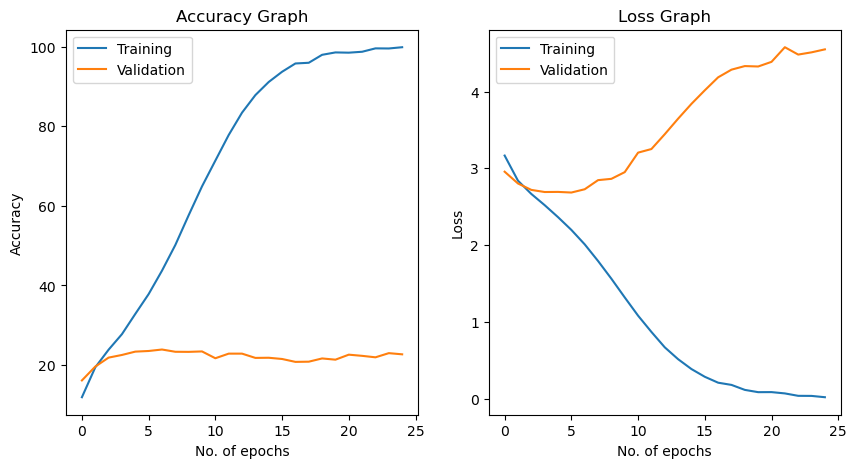

In [21]:
# This function will train and validate the model for specific number of epochs
def mlp_model_train(model, num_epochs, lr ,filename):
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    criterion = model.loss_function()
    optimizer = model.optimizer_function(learning_rate = lr)
    
    train_loader = training_dataloader
    val_loader = validation_dataloader
    
    # Loop over the specified number of epochs
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
    
        print(f"Epoch: {epoch+1}/{num_epochs} Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}% ")
    
    # Save the training and validation loss and accuracy values to a CSV file
    df = pd.DataFrame({'Training Accuracy': train_acc_list, 'Training Loss': train_loss_list, 'Validation Accuracy': val_acc_list, 'Validation Loss': val_loss_list})
    df.to_csv(filename, index=False)

# Creating an instance of the MLP class 
mlp_model = MLP(input_size=64*64*3, hidden_size1=1024, hidden_size2=512, num_classes=30).to(device)

# Train the MLP model with 25 epochs and a learning rate of 0.001
mlp_model_train(mlp_model, num_epochs=25, lr=0.001, filename="mlp_basemodel.csv")

# Display the graph of training and validation accuracy and loss across each epoch
plotgraph(filename="mlp_basemodel.csv", num_epochs=25)

#### CNN Model

Epoch: 1/25 Train Loss: 2.6935, Train Accuracy: 22.69%, Validation Loss: 2.3525, Validation Accuracy: 31.42% 
Epoch: 2/25 Train Loss: 2.1457, Train Accuracy: 37.14%, Validation Loss: 2.1881, Validation Accuracy: 36.49% 
Epoch: 3/25 Train Loss: 1.8261, Train Accuracy: 47.01%, Validation Loss: 1.9068, Validation Accuracy: 44.35% 
Epoch: 4/25 Train Loss: 1.5530, Train Accuracy: 53.47%, Validation Loss: 1.8727, Validation Accuracy: 46.57% 
Epoch: 5/25 Train Loss: 1.2952, Train Accuracy: 61.69%, Validation Loss: 1.9317, Validation Accuracy: 45.35% 
Epoch: 6/25 Train Loss: 1.0499, Train Accuracy: 68.51%, Validation Loss: 1.9497, Validation Accuracy: 45.57% 
Epoch: 7/25 Train Loss: 0.8042, Train Accuracy: 76.37%, Validation Loss: 1.8681, Validation Accuracy: 48.06% 
Epoch: 8/25 Train Loss: 0.5714, Train Accuracy: 84.20%, Validation Loss: 1.9687, Validation Accuracy: 47.83% 
Epoch: 9/25 Train Loss: 0.3799, Train Accuracy: 91.15%, Validation Loss: 2.1599, Validation Accuracy: 44.95% 
Epoch: 10/

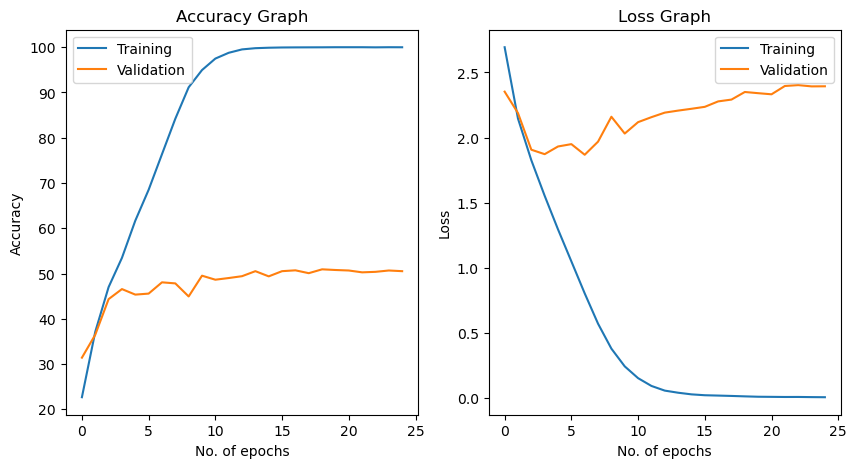

In [22]:
# This function will train and validate the model for specific number of epochs
def cnn_model_train(model, num_epochs, lr, filename):
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    criterion = model.loss_function()
    optimizer = model.optimizer_function(learning_rate = lr)
    
    train_loader = training_dataloader
    val_loader = validation_dataloader
    
    # Loop over the specified number of epochs
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
    
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
    
        print(f"Epoch: {epoch+1}/{num_epochs} Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}% ")
    
    # Save the training and validation loss and accuracy values to a CSV file
    df = pd.DataFrame({'Training Accuracy': train_acc_list, 'Training Loss': train_loss_list, 'Validation Accuracy': val_acc_list, 'Validation Loss': val_loss_list})
    df.to_csv(filename, index=False)
    
# Creating an instance of the CNN class 
cnn_model = CNN(input_size = 8 * 8,num_classes = 30).to(device)

# Train the CNN model with 25 epochs and a learning rate of 0.001
cnn_model_train(cnn_model, num_epochs = 25, lr = 0.001, filename = "cnn_basemodel.csv")

# Display the graph of training and validation accuracy and loss across each epoch
plotgraph(filename = "cnn_basemodel.csv", num_epochs = 25)

#### Comment on your model and results that should include number of parameters in each model and why CNN over MLP for image classification task?

>The MLP model has three fully connected layers. The validation accuracy is around 24%, indicating that the model cannot identify the patterns in the images. The MLP model has a large number of parameters which is 13.1 million, making it more complex and harder to train.

>CNN has four convolutional layers and two fully connected layers. The validation accuracy is approximately 50% which is higher than the MLP model. The number of parameters in the CNN model is around 8.5 million which is less when compared to the MLP model. CNN model detects underlying patterns and features in the images using convolutional layers and then classifies the images. This improves the CNN model's performance in picture classification tasks.

>Although we trained both the MLP and CNN models for 25 epochs, we can see from the graph that the accuracy and loss converge before reaching the maximum number of epochs. For the MLP model, the optimal number of epochs is 20, while for the CNN model it is 15 epochs. This means that after training the model for 20 and 15 epochs respectively, we did not see any significant improvement in the model's performance.

### 2.2 Generating confusion matrix and ROC curves [4 marks]
- Use your CNN architecture with best accuracy to generate two confusion matrices, one for the training set and another for the validation set. Remember to use the whole validation and training sets, and to include all your relevant code. Display the confusion matrices in a meaningful way that clearly indicates what percentage of the data is represented in each position.
- Display ROC curve for 5 top classes with area under the curve

In [156]:
# This function will print the heat map of confusion matrix for validation and training dataset and ROC curve
def get_conf_rocc(model, train_loader, valid_loader, classes):
   
    model.to(device)

    # Get predictions and true labels for training set
    model.eval()
    train_preds = []
    train_true = []
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            train_preds += pred.cpu().numpy().tolist()
            train_true += target.cpu().numpy().tolist()

    # Get predictions and true labels for validation set
    valid_preds = []
    valid_true = []
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            valid_preds += pred.cpu().numpy().tolist()
            valid_true += target.cpu().numpy().tolist()

    # Calculate confusion matrices for training and validation sets
    train_cm = confusion_matrix(train_true, train_preds)
    valid_cm = confusion_matrix(valid_true, valid_preds)

    # Plotting the heat map of confusion matrix for training dataset
    fig, ax = plt.subplots(figsize=(14, 14))
    sns.heatmap(train_cm/train_cm.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2f', cmap='Oranges', annot_kws={'fontsize': 8})
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Training Set')
    plt.show()

    # Plotting the heat map of confusion matrix for validation dataset
    fig, ax = plt.subplots(figsize=(14, 14))
    sns.heatmap(valid_cm/valid_cm.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2f', cmap='Oranges', annot_kws={'fontsize': 8})
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Validation Set')
    plt.show()

    # Plot ROC curves for top five classes
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    top_classes = sorted(range(len(classes)), key=lambda i: -valid_cm[i, i])[:5]
    for i in top_classes:
        class_preds = []
        class_true = []
        for j in range(len(valid_true)):
            if valid_true[j] == i:
                class_preds.append(valid_preds[j])
                class_true.append(1)
            else:
                class_preds.append(valid_preds[j])
                class_true.append(0)
        fpr[i], tpr[i], _ = roc_curve(class_true, class_preds)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    for i in top_classes:
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve for {0} (AUC = {1:0.2f})'.format(classes[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves for top 5 classes')
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, prop={'size': 8})
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

#### Confusion Matrix and ROC curve for base CNN model


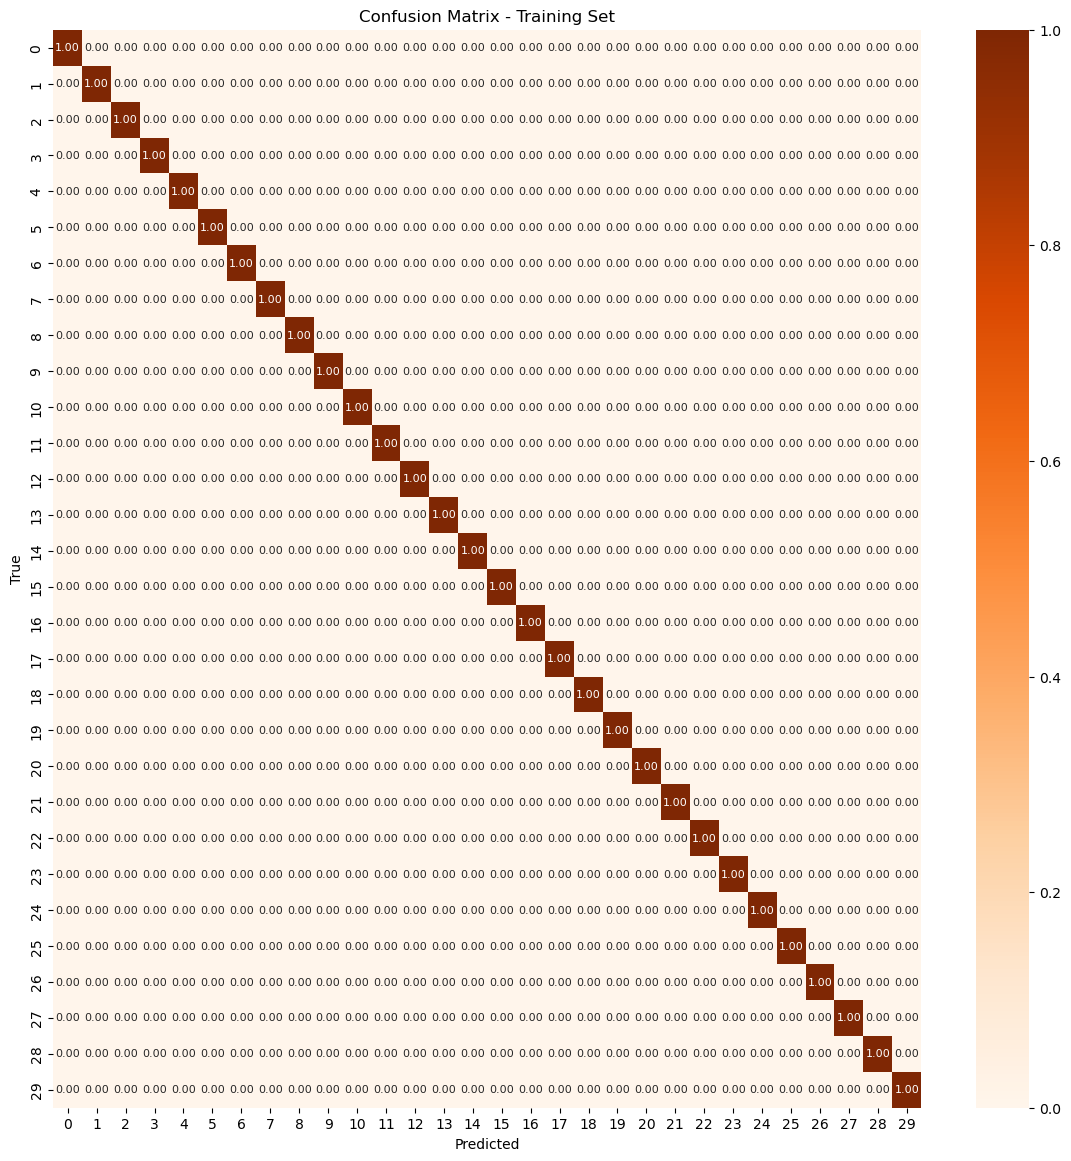

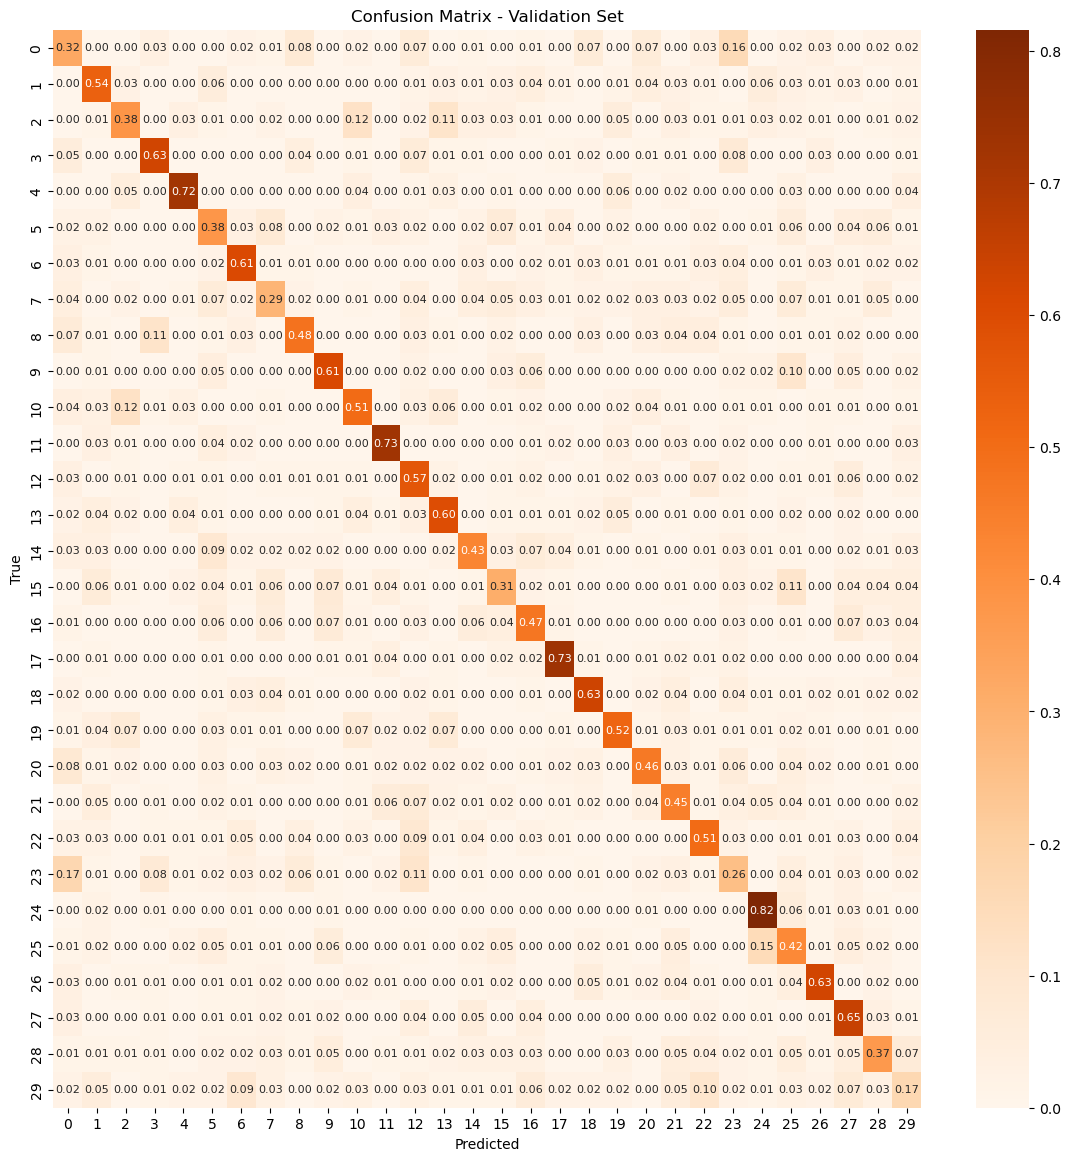

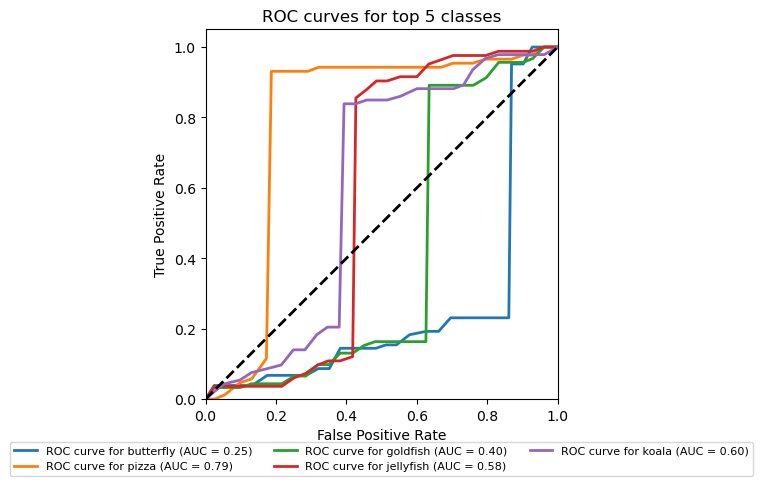

In [157]:
get_conf_rocc(cnn_model, training_dataloader, validation_dataloader, class_names)

#### Confusion Matrix and ROC curve for my best model

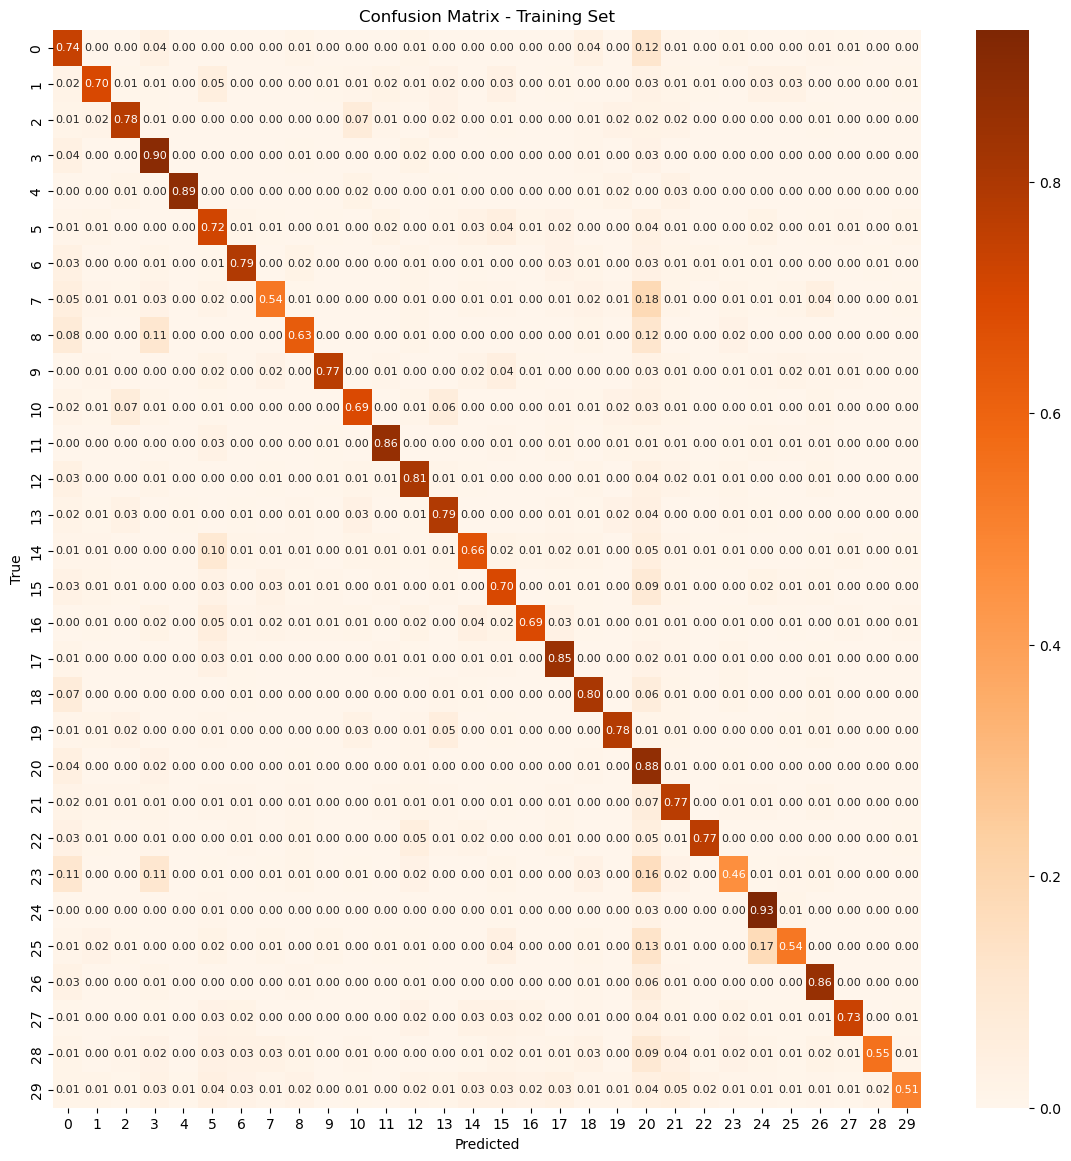

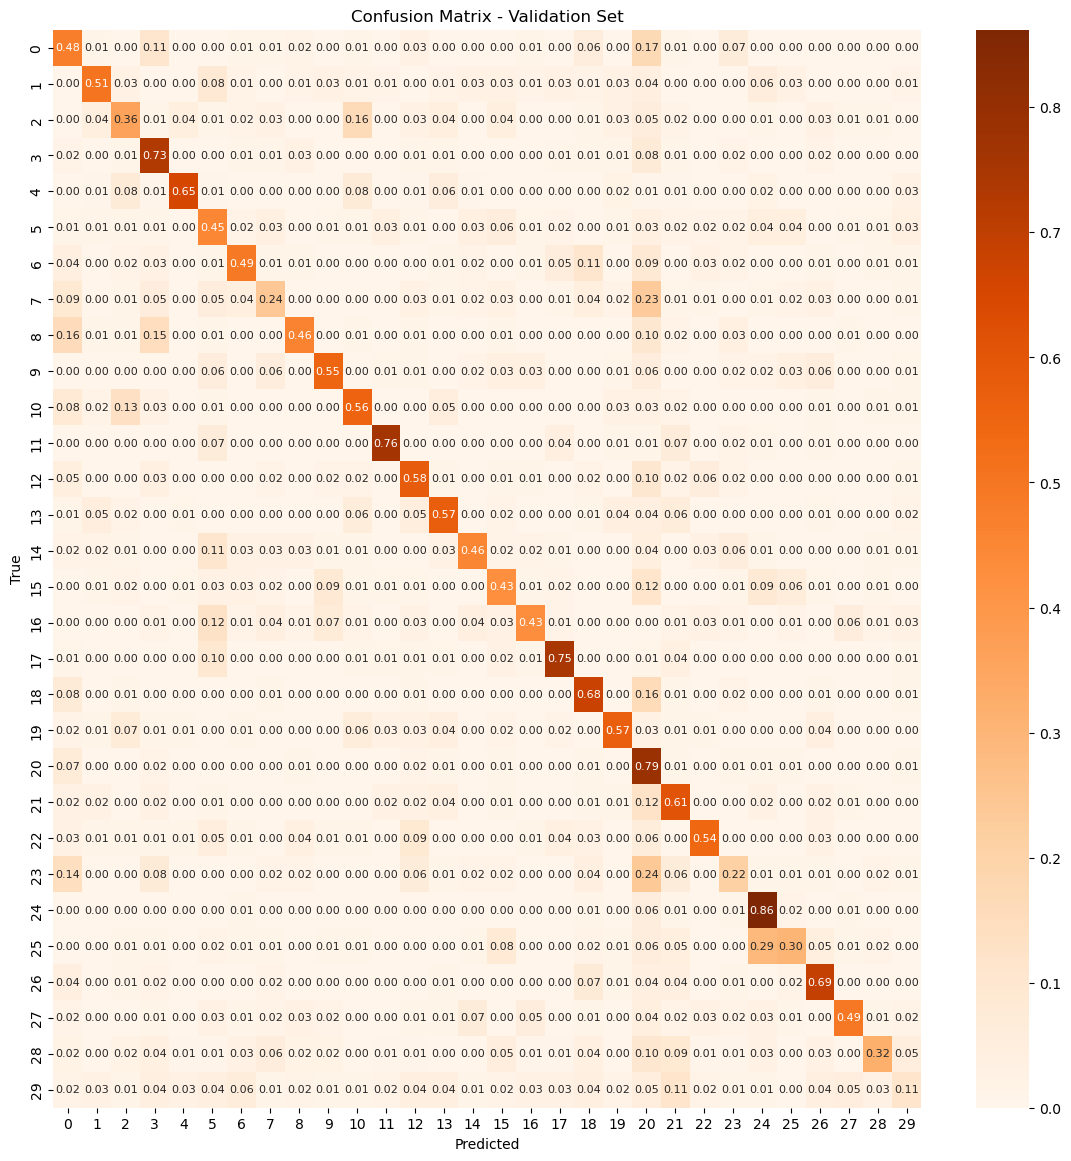

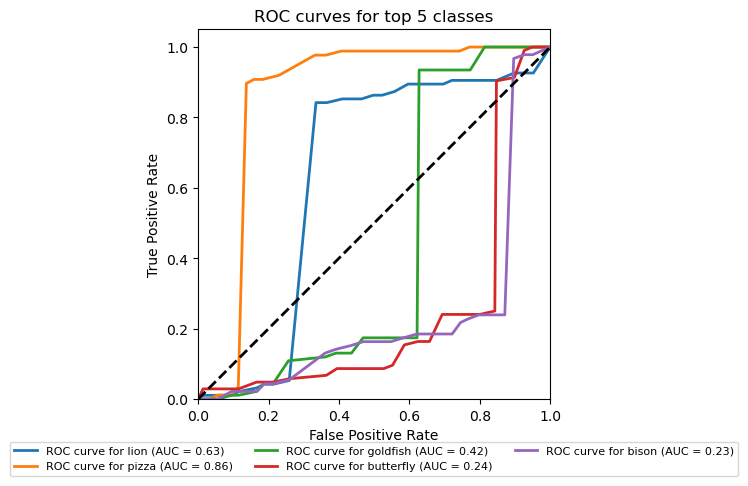

In [158]:
get_conf_rocc(cnn_dropmodel, training_dataloader, validation_dataloader, class_names)

**Note: All parts below here relate to the CNN model only and not the MLP! You are advised to use your final CNN model only for each of the following parts.**

### 2.3 Strategies for tackling overfitting (9 marks)
Using your (final) CNN model, use the strategies below to avoid overfitting. You can reuse the network weights from previous training, often referred to as ``fine tuning``. 
*   **2.3.1** Data augmentation
*   **2.3.2** Dropout
*   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)

Plot loss and accuracy graphs per epoch side by side for each implemented strategy.

#### 2.3.1 Data augmentation

> Implement at least five different data augmentation techniques that should include both photometric and geometric augmentations. 

> Provide graph and comment on what you observe


In [25]:
# Defining the data augementation techniques for the dataset
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0), ratio=(0.8, 1.2)),
    transforms.ColorJitter(hue=0.1, saturation=0.5, brightness=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(4),
    transforms.RandomAutocontrast(0.5),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.GaussianBlur(3),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# Load the training and validation datasets, and create dataloaders for them
training_dataset, validation_dataset, training_dataloader, validation_dataloader, class_names = dataloading(train_transform)

Epoch: 1/20 Train Loss: 2.7059, Train Accuracy: 23.28%, Validation Loss: 2.2837, Validation Accuracy: 34.32% 
Epoch: 2/20 Train Loss: 2.1010, Train Accuracy: 38.41%, Validation Loss: 2.0675, Validation Accuracy: 40.45% 
Epoch: 3/20 Train Loss: 1.7783, Train Accuracy: 47.93%, Validation Loss: 1.9258, Validation Accuracy: 43.58% 
Epoch: 4/20 Train Loss: 1.5398, Train Accuracy: 54.61%, Validation Loss: 1.8587, Validation Accuracy: 45.87% 
Epoch: 5/20 Train Loss: 1.2789, Train Accuracy: 62.05%, Validation Loss: 1.8670, Validation Accuracy: 48.10% 
Epoch: 6/20 Train Loss: 1.0380, Train Accuracy: 69.54%, Validation Loss: 1.8583, Validation Accuracy: 47.05% 
Epoch: 7/20 Train Loss: 0.7995, Train Accuracy: 76.89%, Validation Loss: 1.9352, Validation Accuracy: 46.92% 
Epoch: 8/20 Train Loss: 0.5783, Train Accuracy: 84.30%, Validation Loss: 1.9891, Validation Accuracy: 48.75% 
Epoch: 9/20 Train Loss: 0.3851, Train Accuracy: 90.86%, Validation Loss: 1.9927, Validation Accuracy: 49.48% 
Epoch: 10/

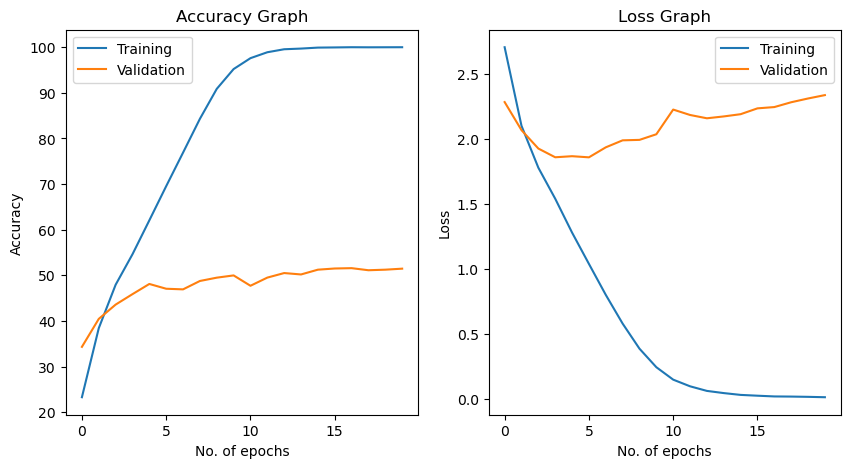

In [26]:
# Creating an instance of the CNN class 
cnn_augmentation_model = CNN(input_size = 8 * 8,num_classes = 30).to(device)

# Train the CNN model with 30 epochs and a learning rate of 0.001
cnn_model_train(cnn_augmentation_model, num_epochs = 20, lr = 0.001, filename = "cnn_dataaugmentationmodel.csv")

# Display the graph of training and validation accuracy and loss across each epoch
plotgraph(filename = "cnn_dataaugmentationmodel.csv", num_epochs = 20)

#### Comments on CNN Model after data augmentation technique

>The CNN model, which was built after applying data augmentation techniques, did not show significant improvement when compared to the base CNN model. Although the validation loss decreased during the initial epochs, it started to increase as the validation accuracy converged. Fine-tuning was attempted on this model by taking the weights from the previous model, but this resulted in overfitting the model.Therefore, based on the observations, this may not be my best model for the given task.


#### 2.3.2 Dropout

> Implement dropout in your model 

> Provide graph and comment on your choice of proportion used

In [53]:
class CNN_DropOut(nn.Module):
    def __init__(self,input_size, num_classes, dropout_prob=0.5):
        super(CNN_DropOut, self).__init__()
        # Defining the four Convolutional layer and Batch normalization layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) 
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        # Adding max pooling layer with kernel size 2x2         
        self.pool = nn.MaxPool2d(2)
        
        # Defining two fully connected layers with given input, output sizes
        self.fc1 = nn.Linear(128 * input_size, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        
        # Adding drop out function
        self.dropout = nn.Dropout(dropout_prob)

    # Defining the forward pass of the model
    def forward(self, x):
        out = self.pool(torch.relu(self.bn1(self.conv1(x))))
        out = self.pool(torch.relu(self.bn2(self.conv2(out))))
        out = self.dropout(out)
        out = self.pool(torch.relu(self.bn3(self.conv3(out))))
        out = self.dropout(out)
        out = torch.relu(self.bn4(self.conv4(out)))
        out = self.dropout(out)
        out = out.reshape(out.shape[0],-1)
        out = torch.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return out

    # This function returns the optimizer function for the model
    def loss_function(self):
        return nn.CrossEntropyLoss()
    
    # This function returns the loss function for the model
    def optimizer_function(self, learning_rate):
        return torch.optim.SGD(self.parameters(), lr=learning_rate, momentum = 0.9)

Epoch: 1/30 Train Loss: 3.2124, Train Accuracy: 9.78%, Validation Loss: 2.9930, Validation Accuracy: 16.40% 
Epoch: 2/30 Train Loss: 2.8237, Train Accuracy: 19.31%, Validation Loss: 2.6585, Validation Accuracy: 23.57% 
Epoch: 3/30 Train Loss: 2.6016, Train Accuracy: 23.86%, Validation Loss: 2.5260, Validation Accuracy: 28.16% 
Epoch: 4/30 Train Loss: 2.4849, Train Accuracy: 27.37%, Validation Loss: 2.4253, Validation Accuracy: 30.19% 
Epoch: 5/30 Train Loss: 2.4158, Train Accuracy: 29.37%, Validation Loss: 2.4057, Validation Accuracy: 30.08% 
Epoch: 6/30 Train Loss: 2.3184, Train Accuracy: 31.69%, Validation Loss: 2.3381, Validation Accuracy: 32.46% 
Epoch: 7/30 Train Loss: 2.2758, Train Accuracy: 32.81%, Validation Loss: 2.3282, Validation Accuracy: 32.95% 
Epoch: 8/30 Train Loss: 2.2022, Train Accuracy: 34.86%, Validation Loss: 2.1835, Validation Accuracy: 37.07% 
Epoch: 9/30 Train Loss: 2.1653, Train Accuracy: 35.94%, Validation Loss: 2.0387, Validation Accuracy: 41.15% 
Epoch: 10/3

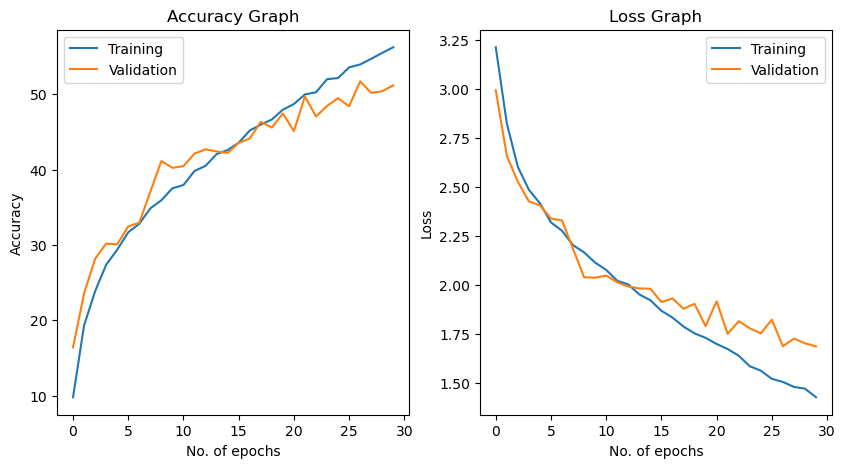

In [58]:
# This function will train and validate the model for specific number of epochs
def cnn_dropmodel_train(model, num_epochs, lr, filename):
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    criterion = model.loss_function()
    optimizer = model.optimizer_function(learning_rate = lr)
    
    train_loader = training_dataloader
    val_loader = validation_dataloader
    
    # Loop over the specified number of epochs
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
    
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
    
        print(f"Epoch: {epoch+1}/{num_epochs} Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}% ")
    
    # Save the training and validation loss and accuracy values to a CSV file
    df = pd.DataFrame({'Training Accuracy': train_acc_list, 'Training Loss': train_loss_list, 'Validation Accuracy': val_acc_list, 'Validation Loss': val_loss_list})
    df.to_csv(filename, index=False)
    
# saving the starting time to calculate the excution time of the model
start_time = time.time()
    
# Creating an instance of the CNN class 
cnn_dropmodel = CNN_DropOut(input_size = 8 * 8,num_classes = 30).to(device)

# Train the CNN model with 30 epochs and a learning rate of 0.001
cnn_dropmodel_train(cnn_dropmodel, num_epochs = 30, lr = 0.001, filename = "cnn_dropmodel.csv")

# saving the end time to calculate the excution time of the model
end_time = time.time()

dropout_exectime = end_time - start_time

# save the model
torch.save(cnn_dropmodel.state_dict(), "/kaggle/working/cnn_dropmodel.pt")

# Display the graph of training and validation accuracy and loss across each epoch
plotgraph(filename = "cnn_dropmodel.csv", num_epochs = 30)

#### Comments on CNN Model after dropout technique

>The CNN model that uses dropout regularization is the best model compared to the other models discussed because it has similar accuracy for both training and validation sets. In the beginning, the training loss is more than the validation loss, but later, the training loss becomes less and follows the trend. The dropout CNN model shows no signs of overfitting or underfitting after the initial epochs, indicating that the model is performing well.So, I am considering this model as best model.The choice of proportion used  here is 0.5 after giving trails on other proportion.


#### 2.3.3 Hyperparameter tuning

> Use learning rates [0.1, 0.001, 0.0001]

> Provide separate graphs for loss and accuracy, each showing performance at three different learning rates

#### CNN model with learing rate 0.1

In [57]:
# Creating an instance of the CNN class 
cnn_model_lr1 = CNN_DropOut(input_size = 8 * 8,num_classes = 30).to(device)

# Train the CNN model with 30 epochs and a learning rate of 0.1
cnn_dropmodel_train(cnn_model_lr1, num_epochs = 30, lr = 0.1, filename = "cnn_lr1_model.csv")

Epoch: 1/30 Train Loss: 3.5067, Train Accuracy: 3.43%, Validation Loss: 3.4115, Validation Accuracy: 3.38% 
Epoch: 2/30 Train Loss: 3.4189, Train Accuracy: 3.01%, Validation Loss: 3.4134, Validation Accuracy: 3.23% 
Epoch: 3/30 Train Loss: 3.4182, Train Accuracy: 3.13%, Validation Loss: 3.4126, Validation Accuracy: 3.56% 
Epoch: 4/30 Train Loss: 3.4173, Train Accuracy: 3.26%, Validation Loss: 3.4127, Validation Accuracy: 3.48% 
Epoch: 5/30 Train Loss: 3.4168, Train Accuracy: 3.25%, Validation Loss: 3.4174, Validation Accuracy: 3.40% 
Epoch: 6/30 Train Loss: 3.4175, Train Accuracy: 3.44%, Validation Loss: 3.4163, Validation Accuracy: 3.37% 
Epoch: 7/30 Train Loss: 3.4168, Train Accuracy: 3.54%, Validation Loss: 3.4141, Validation Accuracy: 3.70% 
Epoch: 8/30 Train Loss: 3.4179, Train Accuracy: 3.09%, Validation Loss: 3.4131, Validation Accuracy: 3.53% 
Epoch: 9/30 Train Loss: 3.4186, Train Accuracy: 3.14%, Validation Loss: 3.4202, Validation Accuracy: 2.68% 
Epoch: 10/30 Train Loss: 3.4

#### CNN model with learing rate 0.001

In [106]:
# Creating an instance of the CNN class 
cnn_model_lr001 = CNN_DropOut(input_size = 8 * 8,num_classes = 30).to(device)

# Train the CNN model with 30 epochs and a learning rate of 0.001
cnn_dropmodel_train(cnn_model_lr001, num_epochs = 30, lr = 0.001, filename = "cnn_lr001_model.csv")


Epoch: 1/30 Train Loss: 3.2005, Train Accuracy: 10.05%, Validation Loss: 2.9343, Validation Accuracy: 17.17% 
Epoch: 2/30 Train Loss: 2.7993, Train Accuracy: 19.66%, Validation Loss: 2.6400, Validation Accuracy: 23.96% 
Epoch: 3/30 Train Loss: 2.6008, Train Accuracy: 24.44%, Validation Loss: 2.5267, Validation Accuracy: 26.21% 
Epoch: 4/30 Train Loss: 2.4813, Train Accuracy: 27.43%, Validation Loss: 2.3957, Validation Accuracy: 30.17% 
Epoch: 5/30 Train Loss: 2.4052, Train Accuracy: 30.19%, Validation Loss: 2.3333, Validation Accuracy: 31.98% 
Epoch: 6/30 Train Loss: 2.3217, Train Accuracy: 31.69%, Validation Loss: 2.1988, Validation Accuracy: 35.34% 
Epoch: 7/30 Train Loss: 2.2661, Train Accuracy: 33.55%, Validation Loss: 2.2350, Validation Accuracy: 33.94% 
Epoch: 8/30 Train Loss: 2.2107, Train Accuracy: 34.39%, Validation Loss: 2.1921, Validation Accuracy: 37.89% 
Epoch: 9/30 Train Loss: 2.1503, Train Accuracy: 36.72%, Validation Loss: 2.1391, Validation Accuracy: 38.66% 
Epoch: 10/

#### CNN model with learing rate 0.0001

In [110]:
# Creating an instance of the CNN class 
cnn_model_lr0001 = CNN_DropOut(input_size = 8 * 8,num_classes = 30).to(device)

# Train the CNN model with 30 epochs and a learning rate of 0.0001
cnn_dropmodel_train(cnn_model_lr0001, num_epochs = 30, lr = 0.0001, filename = "cnn_lr0001_model.csv")

Epoch: 1/30 Train Loss: 3.4208, Train Accuracy: 4.09%, Validation Loss: 3.3715, Validation Accuracy: 9.73% 
Epoch: 2/30 Train Loss: 3.3701, Train Accuracy: 5.66%, Validation Loss: 3.3402, Validation Accuracy: 9.13% 
Epoch: 3/30 Train Loss: 3.3088, Train Accuracy: 8.29%, Validation Loss: 3.2886, Validation Accuracy: 9.99% 
Epoch: 4/30 Train Loss: 3.2162, Train Accuracy: 10.96%, Validation Loss: 3.1946, Validation Accuracy: 10.65% 
Epoch: 5/30 Train Loss: 3.1134, Train Accuracy: 12.58%, Validation Loss: 3.1105, Validation Accuracy: 11.28% 
Epoch: 6/30 Train Loss: 3.0161, Train Accuracy: 14.99%, Validation Loss: 3.0336, Validation Accuracy: 12.88% 
Epoch: 7/30 Train Loss: 2.9541, Train Accuracy: 16.63%, Validation Loss: 2.9749, Validation Accuracy: 13.88% 
Epoch: 8/30 Train Loss: 2.8928, Train Accuracy: 17.34%, Validation Loss: 2.9063, Validation Accuracy: 16.10% 
Epoch: 9/30 Train Loss: 2.8321, Train Accuracy: 19.08%, Validation Loss: 2.8539, Validation Accuracy: 18.18% 
Epoch: 10/30 Tra

#### Comparsion graph for three different learning rates

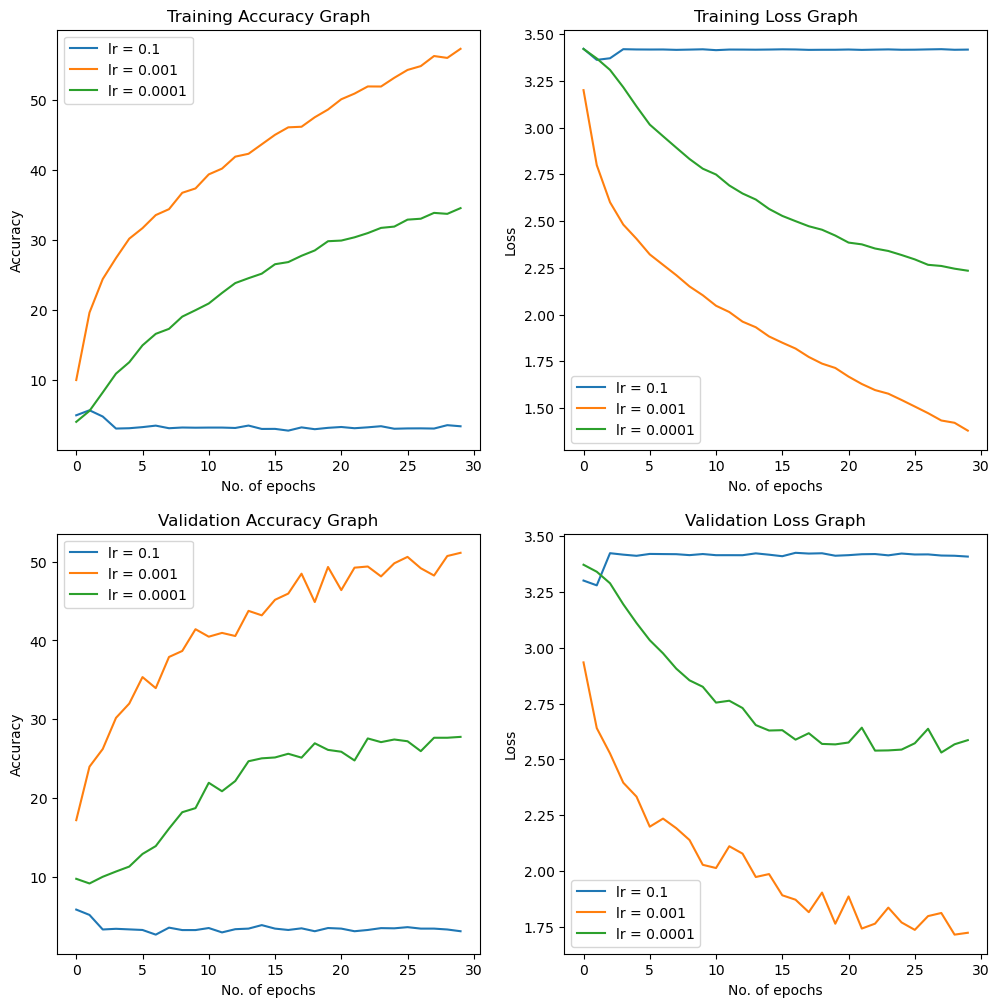

In [189]:
# Graphs for Hyper parameter tuning models
# For both validation and training data, this function will plot the graph for accuracy and loss.
# This function will read data from the csv file that we previously saved after running the model.

def plotgraph_learningrates(filename_1, filename_2, filename_3, num_epochs):
    
    data_1 = pd.read_csv(filename_1)
    data_2 = pd.read_csv(filename_2)
    data_3 = pd.read_csv(filename_3)
        
    x = np.arange(num_epochs)
    
    fig, ax = plt.subplots(2, 2, figsize=(12,12))

    ax[0, 0].plot(x, data_1['Training Accuracy'], label='lr = 0.1')
    ax[0, 0].plot(x, data_2['Training Accuracy'], label='lr = 0.001')
    ax[0, 0].plot(x, data_3['Training Accuracy'], label='lr = 0.0001')
    ax[0, 0].set_title('Training Accuracy Graph')
    ax[0, 0].set_xlabel('No. of epochs')
    ax[0, 0].set_ylabel('Accuracy')
    ax[0, 0].legend()

    ax[0, 1].plot(x, data_1['Training Loss'], label='lr = 0.1')
    ax[0, 1].plot(x, data_2['Training Loss'], label='lr = 0.001')
    ax[0, 1].plot(x, data_3['Training Loss'], label='lr = 0.0001')
    ax[0, 1].set_title('Training Loss Graph')
    ax[0, 1].set_xlabel('No. of epochs')
    ax[0, 1].set_ylabel('Loss')
    ax[0, 1].legend()
    
    ax[1, 0].plot(x, data_1['Validation Accuracy'], label='lr = 0.1')
    ax[1, 0].plot(x, data_2['Validation Accuracy'], label='lr = 0.001')
    ax[1, 0].plot(x, data_3['Validation Accuracy'], label='lr = 0.0001')
    ax[1, 0].set_title('Validation Accuracy Graph')
    ax[1, 0].set_xlabel('No. of epochs')
    ax[1, 0].set_ylabel('Accuracy')
    ax[1, 0].legend()
    
    ax[1, 1].plot(x, data_1['Validation Loss'], label='lr = 0.1')
    ax[1, 1].plot(x, data_2['Validation Loss'], label='lr = 0.001')
    ax[1, 1].plot(x, data_3['Validation Loss'], label='lr = 0.0001')
    ax[1, 1].set_title('Validation Loss Graph')
    ax[1, 1].set_xlabel('No. of epochs')
    ax[1, 1].set_ylabel('Loss')
    ax[1, 1].legend()
    
    plt.show()


plotgraph_learningrates(filename_1 = "cnn_lr1_model.csv", filename_2 = "cnn_lr001_model.csv", 
                        filename_3 = "cnn_lr0001_model.csv", num_epochs = 30)

### 3 Model testing [18 marks]
Online evaluation of your model performance on the test set.

> Prepare the dataloader for test set

> Write evaluation code for writing predictions

> Upload it to Kaggle submission page [link](https://www.kaggle.com/t/917fe52f6a3c4855880a24b34f26db07) 


#### 3.1 Test class and predictions [10 marks]

> Build a test class, prepare a test dataloader and generate predictions 

Create a PyTorch ```Dataset``` for the unlabeled test data in the test_set folder of the Kaggle competition and generate predictions using your final model. Test data can be downloaded [here](https://www.kaggle.com/competitions/comp5623m-artificial-intelligence/data?select=test_set)

In [102]:
# Class for loading test datasets
class TestFolderData(torch.utils.data.Dataset):
    
    # Initialize the dataset with image directory
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.file_names = os.listdir(self.folder_path)
        
    # This function returns the number of samples in the dataset
    def __len__(self):
        return len(self.file_names)
    
    # This function returns the image and the image file name.
    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.file_names[idx])
        image =  torchvision.datasets.folder.default_loader(img_path)
        if self.transform:
            image = self.transform(image)
        return self.file_names[idx],image

#### 3.2 Prepare your submission and upload to Kaggle [8 marks]

Save all test predictions to a CSV file and submit it to the private class Kaggle competition. **Please save your test CSV file submissions using your student username (the one with letters, ie., ``sc15jb``, not the ID with only numbers)**, for example, `sc15jb.csv`. That will help us to identify your submissions.

The CSV file must contain only two columns: ‘Id’ and ‘Category’ (predicted class ID) as shown below:

```txt
Id,Category
28d0f5e9_373c.JPEG,2
bbe4895f_40bf.JPEG,18
```

Please note you will get marks for higher performance.

The ‘Id’ column should include the name of the image. It is important to keep the same name as the one on the test set. Do not include any path, just the name of file (with extension). Your csv file must contain 1501 rows, one for each image in the test set and 1 row for the headers. [To submit please visit](https://www.kaggle.com/t/917fe52f6a3c4855880a24b34f26db07)

> You may submit multiple times. We will use your personal top entry for allocating marks for this [8 marks]. The class leaderboard will not affect marking (brownie points!).


In [103]:
# This function will evaluate the test data and save the result in CSV file with image file name and predicted label
def generate_predictions(model, test_dataloader, output_file):
    model.eval()
    model.to(device)

    predictions = []
    file_names = []

    for batch, (file_name, images) in enumerate(test_dataloader):
        images = images.to(device)

        with torch.no_grad():
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

        predictions.extend(predicted.tolist())
        file_names.extend(file_name)

    # Create a dataframe with the file names and predictions, and save the results to a CSV file
    results_df = pd.DataFrame({'Id': file_names, 'Category': predictions})
    results_df.to_csv(output_file, index=False)


In [267]:
# Define the image preprocessing steps
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load the dataset of images and apply the transformation
data_dir = '/kaggle/input/test-data/test_set/test_set'
dataset = TestFolderData(data_dir , transform=transform)

# Create a DataLoader for the testing set
testdataloader = DataLoader(dataset, batch_size=12, shuffle=False, num_workers= 2)

# This function will evaluate the test data
generate_predictions(cnn_dropmodel, testdataloader, 'mm22mkm.csv')

#### Display function of testing dataset

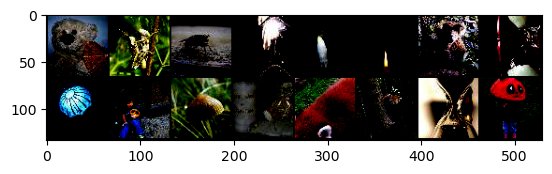

('46c571e0_a64d.JPEG', 'a31df4c1_695a.JPEG', '8677335a_fa75.JPEG', '08f02b24_cd1e.JPEG', '60dc62d7_5f9d.JPEG', '6cda1a1d_30b1.JPEG', '7b8e1487_9661.JPEG', '2d7cc2a9_0472.JPEG', '3552e203_55c0.JPEG', '166abd7a_fd34.JPEG', 'af99bb93_1318.JPEG', '547b4bab_e558.JPEG', '4b1fe570_e969.JPEG', 'c955c081_4b76.JPEG', '154f008f_9fd9.JPEG', '9016b72d_a407.JPEG')


In [41]:
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.show()
     
data_iter = iter(testdataloader)
filename, images = next(data_iter)

# show images and labels
timshow(torchvision.utils.make_grid(images))
# print(f"labels {[filename[labels[i]] for i in range(16)]}")
print(filename)


### 4 Model Fine-tuning/transfer learning on CIFAR10 dataset  [20 marks]

Fine-tuning is a way of applying or utilizing transfer learning. It is a process that takes a model that has already been trained for one task and then tunes or tweaks the model to make it perform a second similar task. You can perform finetuning in the following way:
- Train an entire model from scratch (large dataset, more computation)
- Freeze convolution base and train only last FC layers (small dataset and lower computation) 

> **Configuring your dataset**
   - Download your dataset using ``torchvision.datasets.CIFAR10``, [explained here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)
   - Split training dataset into training and validation set similar to above. *Note that the number of categories here are only 10*


In [59]:
# Define the image preprocessing steps
cifar_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Download and load the CIFAR10 dataset
cifar_train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=cifar_transform)

# Set the random seed for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

# Splitting the dataset for validation and training in an 80:20 ratio     
cifar_train_size = int(0.8 * len(cifar_train_data))
cifar_val_size = len(cifar_train_data) - cifar_train_size
cifar_train_data, cifar_val_data = torch.utils.data.random_split(cifar_train_data, [cifar_train_size, cifar_val_size])

# Create data loaders
batch_size = 64
cifar_train_loader = torch.utils.data.DataLoader(cifar_train_data, batch_size=batch_size, shuffle=True, num_workers= 2,
                                                 generator=torch.Generator().manual_seed(0))
cifar_val_loader = torch.utils.data.DataLoader(cifar_val_data, batch_size=batch_size, shuffle=False, num_workers= 2)

Files already downloaded and verified


> Load pretrained AlexNet from PyTorch - use model copies to apply transfer learning in different configurations

In [83]:
#  Loading the pretrained alexnet model and the normal alexnet model
alexnet_pretrained = torchvision.models.alexnet(pretrained=True)
alexnet = torchvision.models.alexnet()

# Applying Finetuning to the normal alexnet model
alexnet.load_state_dict(alexnet_pretrained.state_dict())

# Modify the last layer for CIFAR-10 classification
num_ftrs = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_ftrs, 10)

alexnet = alexnet.to(device)

# printing the summary of the number of parameters 
summary(alexnet, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 31, 31]          23,296
              ReLU-2           [-1, 64, 31, 31]               0
         MaxPool2d-3           [-1, 64, 15, 15]               0
            Conv2d-4          [-1, 192, 15, 15]         307,392
              ReLU-5          [-1, 192, 15, 15]               0
         MaxPool2d-6            [-1, 192, 7, 7]               0
            Conv2d-7            [-1, 384, 7, 7]         663,936
              ReLU-8            [-1, 384, 7, 7]               0
            Conv2d-9            [-1, 256, 7, 7]         884,992
             ReLU-10            [-1, 256, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]         590,080
             ReLU-12            [-1, 256, 7, 7]               0
        MaxPool2d-13            [-1, 256, 3, 3]               0
AdaptiveAvgPool2d-14            [-1, 25

#### 4.1 Apply transfer learning initialise with pretrained model weights
Use pretrained weights from AlexNet only (on the right of figure) to initialise your model. 

<img src="https://upload.wikimedia.org/wikipedia/commons/c/cc/Comparison_image_neural_networks.svg" style="width:1000px;height:400px;">
<caption><center> <u>Figure</u>: Two models are given here: LeNet and AlexNet for image classification. However, you have to use **only AlexNet**.</center></caption>


> Configuration 1: No frozen layers

In [84]:
# This function will train and validate cifar data  over the alex model for specific number of epochs 
def cifar_model_train(model, num_epochs, lr, filename):
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr= lr, momentum = 0.9)
    
    train_loader = cifar_train_loader
    val_loader = cifar_val_loader
    
    # Loop over the specified number of epochs
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
    
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
    
        print(f"Epoch: {epoch+1}/{num_epochs} Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}% ")
    
    # Save the training and validation loss and accuracy values to a CSV file
    df = pd.DataFrame({'Training Accuracy': train_acc_list, 'Training Loss': train_loss_list, 'Validation Accuracy': val_acc_list, 'Validation Loss': val_loss_list})
    df.to_csv(filename, index=False)

# Train the AlexNet model over the CIFAR-10 with 30 epochs and a learning rate of 0.001
cifar_model_train(alexnet, num_epochs = 30, lr = 0.001, filename = "cifar_results.csv")

Epoch: 1/30 Train Loss: 1.1096, Train Accuracy: 60.40%, Validation Loss: 0.9237, Validation Accuracy: 67.66% 
Epoch: 2/30 Train Loss: 0.8967, Train Accuracy: 68.19%, Validation Loss: 0.8183, Validation Accuracy: 71.07% 
Epoch: 3/30 Train Loss: 0.8209, Train Accuracy: 71.10%, Validation Loss: 0.8061, Validation Accuracy: 71.52% 
Epoch: 4/30 Train Loss: 0.7833, Train Accuracy: 72.35%, Validation Loss: 0.7501, Validation Accuracy: 73.48% 
Epoch: 5/30 Train Loss: 0.7468, Train Accuracy: 73.62%, Validation Loss: 0.7589, Validation Accuracy: 73.32% 
Epoch: 6/30 Train Loss: 0.7293, Train Accuracy: 74.36%, Validation Loss: 0.7401, Validation Accuracy: 73.96% 
Epoch: 7/30 Train Loss: 0.6982, Train Accuracy: 75.20%, Validation Loss: 0.6875, Validation Accuracy: 76.59% 
Epoch: 8/30 Train Loss: 0.6852, Train Accuracy: 75.88%, Validation Loss: 0.6766, Validation Accuracy: 76.22% 
Epoch: 9/30 Train Loss: 0.6598, Train Accuracy: 76.66%, Validation Loss: 0.6807, Validation Accuracy: 76.07% 
Epoch: 10/

#### 4.2 Fine-tuning model with frozen layers

> Configuration 2: Frozen base convolution blocks

In [73]:
# Loading the alexnet model
alexnet_pretrained = torchvision.models.alexnet(pretrained=True)
frozen_model = torchvision.models.alexnet()

# Applying Finetuning to the normal alexnet model
frozen_model.load_state_dict(alexnet_pretrained.state_dict())

# The frozen_model will have AlexNet model with freezing layers
for param in frozen_model.features.parameters():
    param.requires_grad = False

# Modify the last layer for CIFAR-10 classification
num_ftrs = frozen_model.classifier[6].in_features
frozen_model.classifier[6] = nn.Linear(num_ftrs, 10)
    
frozen_model = frozen_model.to(device)

# Train the AlexNet model over the CIFAR-10 with 15 epochs and a learning rate of 0.001
cifar_model_train(frozen_model, num_epochs = 30, lr = 0.001, filename = "cifar_frozen_model_results.csv")

Epoch: 1/30 Train Loss: 1.2019, Train Accuracy: 56.60%, Validation Loss: 1.0332, Validation Accuracy: 63.13% 
Epoch: 2/30 Train Loss: 1.0604, Train Accuracy: 61.87%, Validation Loss: 0.9801, Validation Accuracy: 64.92% 
Epoch: 3/30 Train Loss: 1.0145, Train Accuracy: 63.51%, Validation Loss: 0.9368, Validation Accuracy: 67.12% 
Epoch: 4/30 Train Loss: 0.9919, Train Accuracy: 64.46%, Validation Loss: 0.9178, Validation Accuracy: 67.31% 
Epoch: 5/30 Train Loss: 0.9692, Train Accuracy: 65.25%, Validation Loss: 0.9145, Validation Accuracy: 67.26% 
Epoch: 6/30 Train Loss: 0.9482, Train Accuracy: 66.16%, Validation Loss: 0.8938, Validation Accuracy: 68.20% 
Epoch: 7/30 Train Loss: 0.9393, Train Accuracy: 66.46%, Validation Loss: 0.8744, Validation Accuracy: 69.26% 
Epoch: 8/30 Train Loss: 0.9161, Train Accuracy: 67.33%, Validation Loss: 0.8719, Validation Accuracy: 69.47% 
Epoch: 9/30 Train Loss: 0.9152, Train Accuracy: 67.34%, Validation Loss: 0.8604, Validation Accuracy: 69.16% 
Epoch: 10/

#### 4.3 Compare above configurations and comment on comparative performance

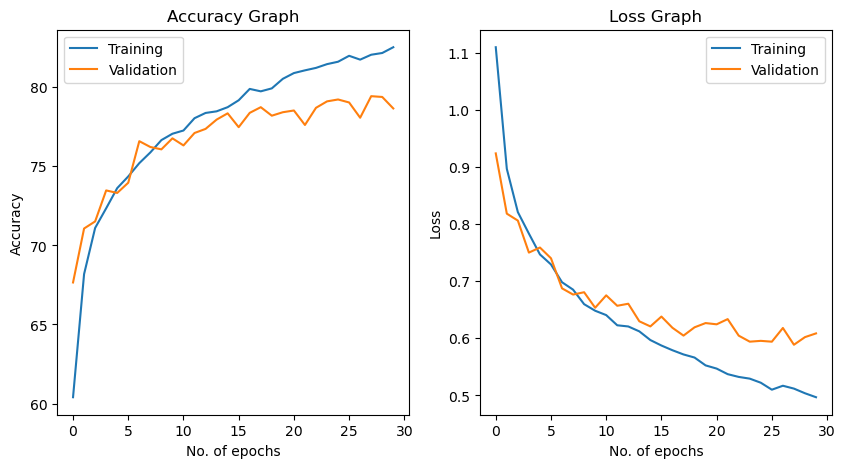

In [85]:
# Display the graph of training and validation accuracy and loss across each epoch
plotgraph(filename = "cifar_results.csv", num_epochs = 30)

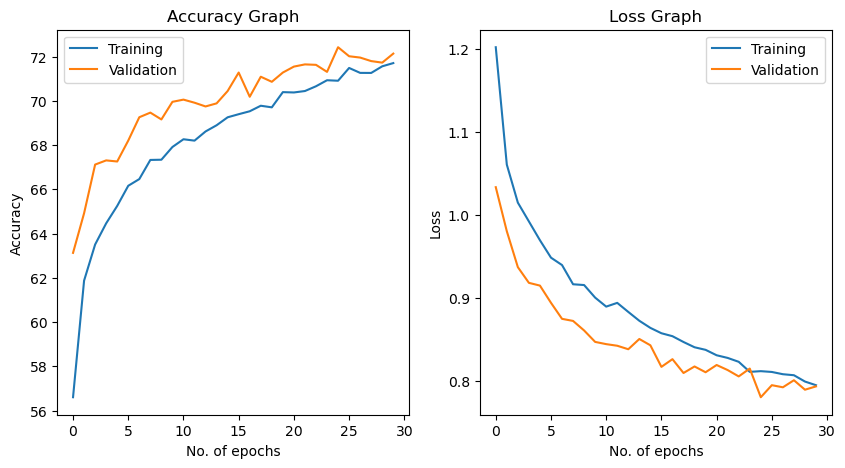

In [74]:
# Display the graph of training and validation accuracy and loss across each epoch
plotgraph(filename = "cifar_frozen_model_results.csv", num_epochs = 30)

#### Comments:

>The AlexNet model trained on the CIFAR10 dataset achieved the highest accuracy of 78.7% on the validation set, indicating good performance. The model did not exhibit any signs of overfitting or underfitting, as seen in the consistent decrease of loss for both the training and validation data. On the other hand, the AlexNet model with frozen layers, which essentially becomes a multilayer perceptron (MLP) with no convolutional layers, achieved a lower accuracy of 71.7% on the validation set. This is likely due to the fact that an MLP is not an appropriate model for image classification tasks. Therefore, we can conclude that the AlexNet model trained on CIFAR10 is the best model for this task.

### 5 Model comparisons
We often need to compare our model with other state-of-the-art methods to understand how well it performs compared to existing architectures. Here you will thus compare your model design with AlexNet on the TinyImageNet30 dataset

#### 5.1 Finetune AlexNet on TinyImageNet30
> Load AlexNet as you did above

> Train AlexNet on TinyImageNet30 dataset until convergence. Make sure you use the same dataset

In [36]:
# This function will train and validate TinyImageNet30 dataset over the alex model for specific number of epochs 
def alex_tiny_model(model, num_epochs, lr, filename):
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    train_loader = training_dataloader
    val_loader = validation_dataloader
    
    # Loop over the specified number of epochs
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
    
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
    
        print(f"Epoch: {epoch+1}/{num_epochs} Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}% ")
    
    # Save the training and validation loss and accuracy values to a CSV file
    df = pd.DataFrame({'Training Accuracy': train_acc_list, 'Training Loss': train_loss_list, 'Validation Accuracy': val_acc_list, 'Validation Loss': val_loss_list})
    df.to_csv(filename, index=False)

Epoch: 1/30 Train Loss: 1.8314, Train Accuracy: 47.86%, Validation Loss: 1.5117, Validation Accuracy: 55.52% 
Epoch: 2/30 Train Loss: 1.1838, Train Accuracy: 64.56%, Validation Loss: 1.4350, Validation Accuracy: 57.94% 
Epoch: 3/30 Train Loss: 0.8298, Train Accuracy: 73.96%, Validation Loss: 1.4571, Validation Accuracy: 59.55% 
Epoch: 4/30 Train Loss: 0.5648, Train Accuracy: 82.01%, Validation Loss: 1.5372, Validation Accuracy: 59.63% 
Epoch: 5/30 Train Loss: 0.3912, Train Accuracy: 87.22%, Validation Loss: 1.5438, Validation Accuracy: 60.77% 
Epoch: 6/30 Train Loss: 0.2544, Train Accuracy: 91.56%, Validation Loss: 1.7432, Validation Accuracy: 62.29% 
Epoch: 7/30 Train Loss: 0.1956, Train Accuracy: 93.76%, Validation Loss: 1.8901, Validation Accuracy: 60.40% 
Epoch: 8/30 Train Loss: 0.1587, Train Accuracy: 95.19%, Validation Loss: 1.9156, Validation Accuracy: 60.29% 
Epoch: 9/30 Train Loss: 0.1176, Train Accuracy: 96.33%, Validation Loss: 1.9871, Validation Accuracy: 62.12% 
Epoch: 10/

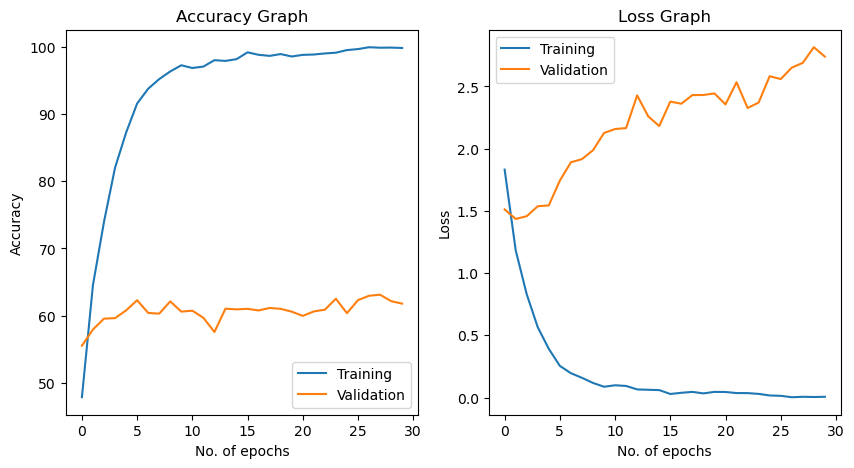

In [38]:
# saving the starting time to calculate the excution time of the model
start_time = time.time()

# Loading the pretrained alexnet model and the normal alexnet model
alexnet_pretrained = torchvision.models.alexnet(pretrained=True)
alexnet_tiny = torchvision.models.alexnet()

# Applying Finetuning to the normal alexnet model
alexnet_tiny.load_state_dict(alexnet_pretrained.state_dict())

# Modify the last layer for TinyImageNet30 classification
num_ftrs = alexnet_tiny.classifier[6].in_features
alexnet_tiny.classifier[6] = nn.Linear(num_ftrs, 30)

alexnet_tiny = alexnet_tiny.to(device)

# Train the AlexNet model over the TinyImageNet30 with 30 epochs and a learning rate of 0.001
alex_tiny_model(alexnet_tiny, num_epochs = 30, lr = 0.0001, filename = "alex_tiny_results.csv")

# saving the end time to calculate the excution time of the model
end_time = time.time()

alexexecution_time = end_time - start_time

# save the model
torch.save(alexnet_tiny.state_dict(), "/kaggle/working/alexnet.pt")

# Display the graph of training and validation accuracy and loss across each epoch
plotgraph(filename = "alex_tiny_results.csv", num_epochs = 30)

#### 5.2 Compare results on validation set of TinyImageNet30
> Loss graph, top1 accuracy, confusion matrix and execution time for your model (say, mymodel and AlexNet)


#### Loss graph and Top1 accuracy for AlexNet and mymodel

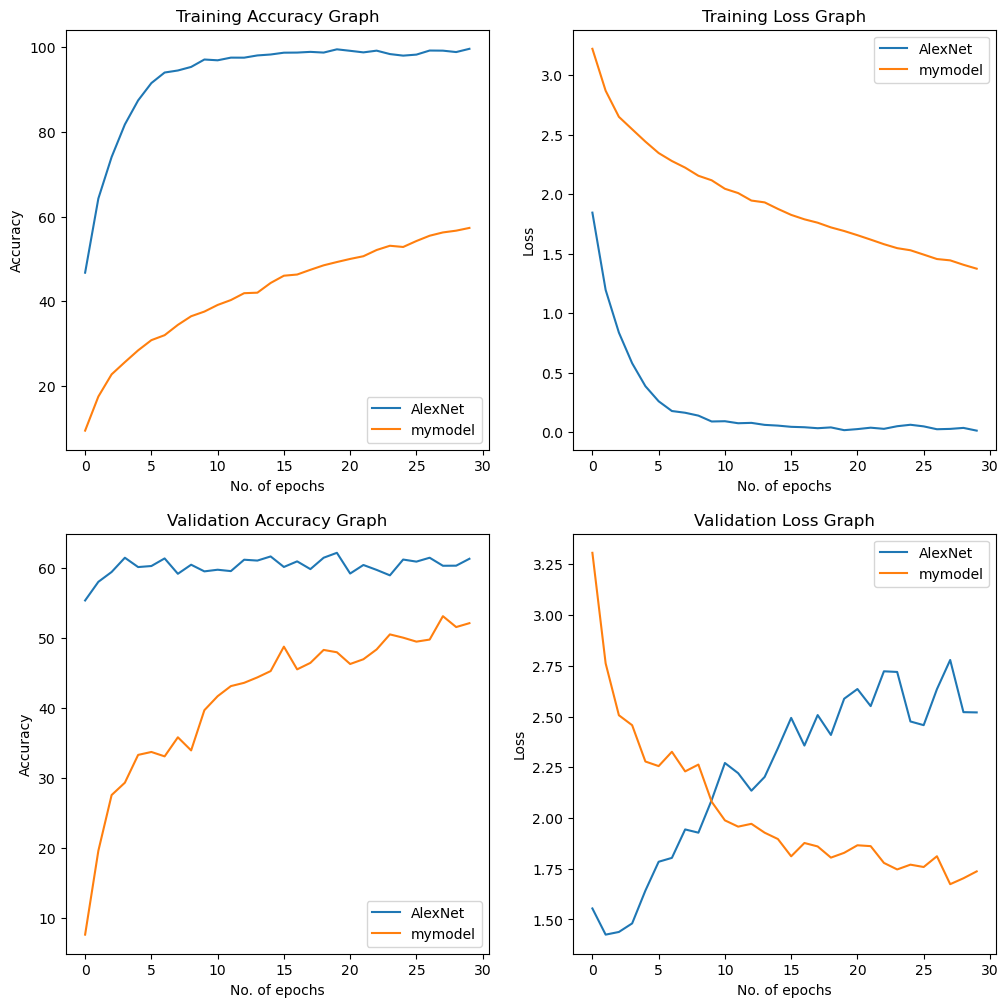

In [190]:
# Graphs for mymodel and alexnet model
# For both validation and training data, this function will plot the graph for accuracy and loss.
# This function will read data from the csv file that we previously saved after running the model.

def plotgraph_model(filename_1, filename_2, num_epochs):
    
    data_1 = pd.read_csv(filename_1)
    data_2 = pd.read_csv(filename_2)
   
    x = np.arange(num_epochs)
    
    fig, ax = plt.subplots(2, 2, figsize=(12,12))

    ax[0, 0].plot(x, data_1['Training Accuracy'], label='AlexNet')
    ax[0, 0].plot(x, data_2['Training Accuracy'], label='mymodel')
    ax[0, 0].set_title('Training Accuracy Graph')
    ax[0, 0].set_xlabel('No. of epochs')
    ax[0, 0].set_ylabel('Accuracy')
    ax[0, 0].legend()

    ax[0, 1].plot(x, data_1['Training Loss'], label='AlexNet')
    ax[0, 1].plot(x, data_2['Training Loss'], label='mymodel')
    ax[0, 1].set_title('Training Loss Graph')
    ax[0, 1].set_xlabel('No. of epochs')
    ax[0, 1].set_ylabel('Loss')
    ax[0, 1].legend()
    
    ax[1, 0].plot(x, data_1['Validation Accuracy'], label='AlexNet')
    ax[1, 0].plot(x, data_2['Validation Accuracy'], label='mymodel')
    ax[1, 0].set_title('Validation Accuracy Graph')
    ax[1, 0].set_xlabel('No. of epochs')
    ax[1, 0].set_ylabel('Accuracy')
    ax[1, 0].legend()
    
    ax[1, 1].plot(x, data_1['Validation Loss'], label='AlexNet')
    ax[1, 1].plot(x, data_2['Validation Loss'], label='mymodel')
    ax[1, 1].set_title('Validation Loss Graph')
    ax[1, 1].set_xlabel('No. of epochs')
    ax[1, 1].set_ylabel('Loss')
    ax[1, 1].legend()
    
    plt.show()


plotgraph_model(filename_1 = "alex_tiny_results.csv", filename_2 = "cnn_dropmodel.csv" , num_epochs = 30)

#### Confusion Matrix

In [191]:
# This function will print the heat map of confusion matrix for validation and training dataset and ROC curve
def get_conf(model, valid_loader, classes):
   
    model.to(device)

   # Get predictions and true labels for validation set
    valid_preds = []
    valid_true = []
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            valid_preds += pred.cpu().numpy().tolist()
            valid_true += target.cpu().numpy().tolist()

    valid_cm = confusion_matrix(valid_true, valid_preds)

    # Plotting the heat map of confusion matrix for validation dataset
    fig, ax = plt.subplots(figsize=(14, 14))
    sns.heatmap(valid_cm/valid_cm.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2f', cmap='Oranges', annot_kws={'fontsize': 8})
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

#### Confusion matrix for AlexNet validation dataset

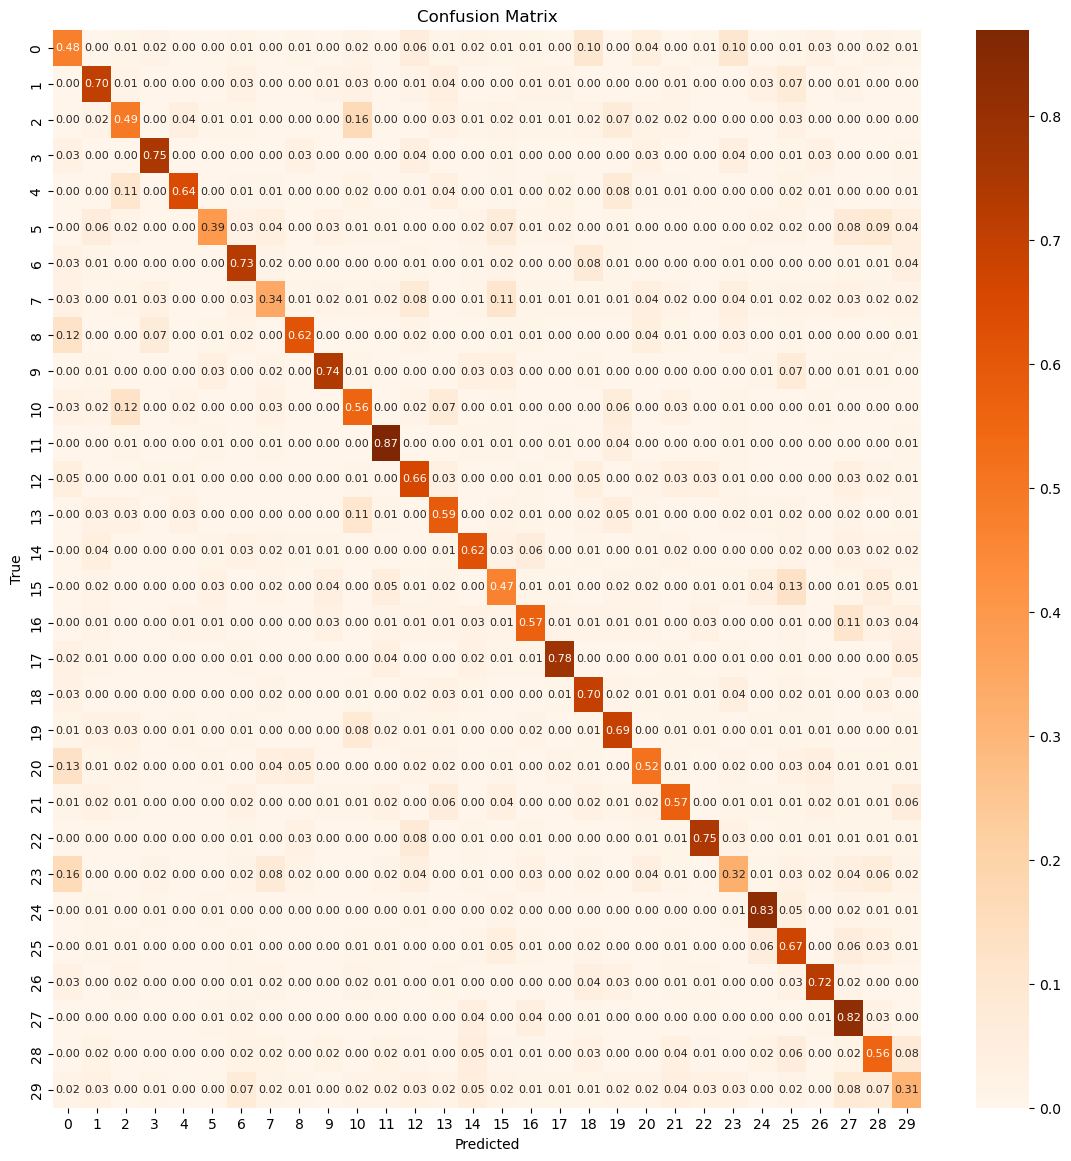

In [192]:
get_conf(alexnet_tiny, validation_dataloader, class_names)

#### Confusion matrix for my model validation dataset

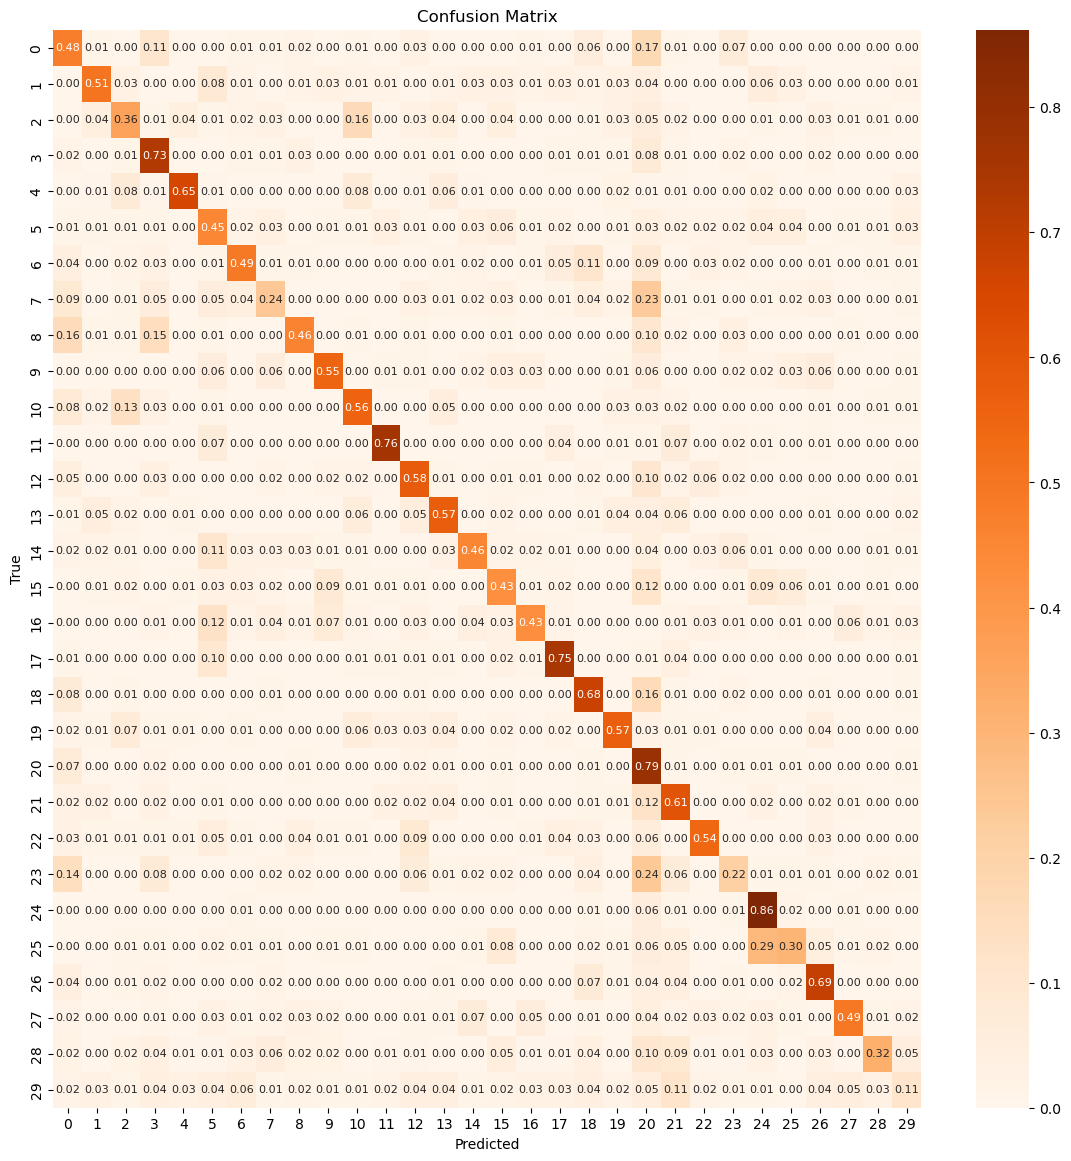

In [193]:
get_conf(cnn_dropmodel, validation_dataloader, class_names)

#### Execution Time for MyModel and AlexNet Model


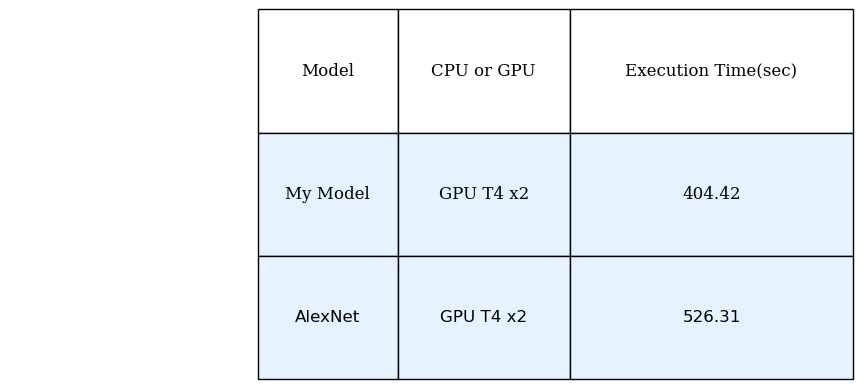

In [185]:
# table contain excution time information , time per sample , CPU/GPU for alexnet and my model
data = [["My Model", "GPU T4 x2", round(dropout_exectime, 2)],
        ["AlexNet", "GPU T4 x2", round(alexexecution_time, 2)]]

fig, ax = plt.subplots()
table_data = ax.table(cellText=data, colLabels=["Model", "CPU or GPU", "Execution Time(sec)"],
                      cellLoc='center', cellColours=[['#e6f2ff']*3]*2, bbox=[0.5, 0, 1.2, 1])


table_data.auto_set_font_size(False)
table_data.set_fontsize(12)

for i in range(len(data)):
    for j in range(len(data[0])):
        cell = table_data.get_celld()[i, j]
        cell.set_text_props(fontfamily='serif', fontsize=12)

ax.set_axis_off()
table_data.auto_set_column_width(col=list(range(len(data[0]))))

plt.show()


### 6 Interpretation of results (16 marks)

> Please use TinyImageNet30 dataset for all results


#### 6.1-6.2 Implement grad-CAM and visualise results (10 marks)

- Use an existing library to initiate grad-CAM 

        - To install: !pip install torchcam
        - Call SmoothGradCAMpp: from torchcam.methods import SmoothGradCAMpp
        - Apply to your model 

You can see the details here: https://github.com/frgfm/torch-cam

- Apply grad-CAM to your model on at least four correctly classified images
- Apply grad-CAM on retrained AlexNet on at least four incorrectly classified images

>It is recommended to first read the relevant paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391), and refer to relevant course material.


**HINT for displaying images with grad-CAM:**

Display ```heatmap``` as a coloured heatmap superimposed onto the original image. We recommend the following steps to get a clear meaningful display. 

From torchcam.utils import overlay_mask. But remember to resize your image, normalise it and put a 1 for the batch dimension (e.g, [1, 3, 224, 224]) 


In [22]:
# Your code here!
!pip install torchcam

In [47]:
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import cv2

#### Applying grad-CAM to my model on four correctly classified images

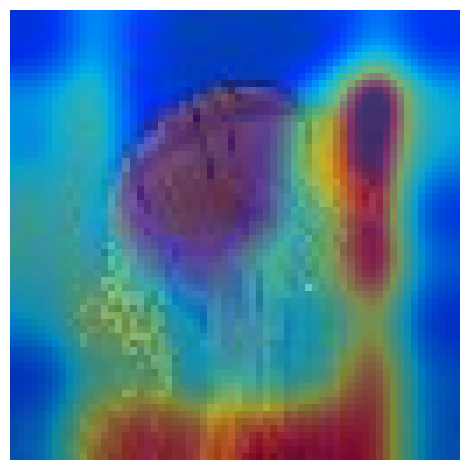

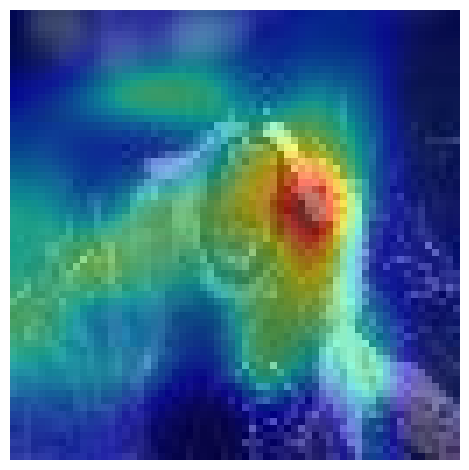

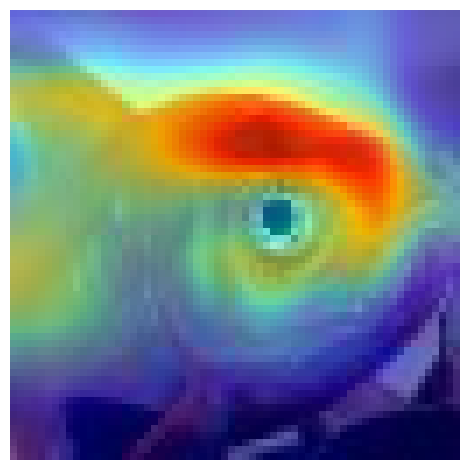

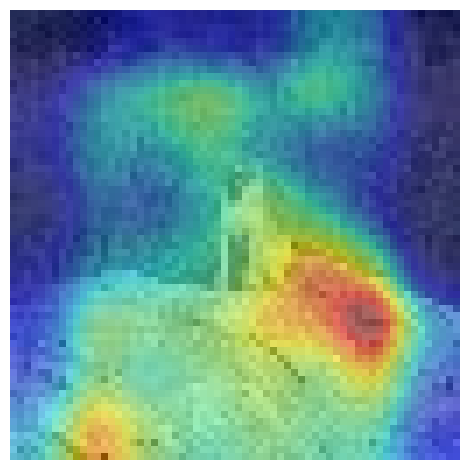

In [89]:
image_paths = ['86e47fac_9c14.JPEG', '38c7e3a4_3df9.JPEG', 'd02a4e07_8f8a.JPEG', '69058482_40d2.JPEG']

transform = transforms.Compose([
    transforms.ToTensor(),
])

images = []
for image_path in image_paths:
    img = Image.open('/kaggle/input/test-data/test_set/test_set/' + image_path)
    img = transform(img)
    images.append(img)

model = CNN_DropOut(input_size=8*8, num_classes=30)
model.to(device)
weights = torch.load('cnn_dropmodel.pt')
model.load_state_dict(weights)
model.eval()

last_conv_layer_name = [name for name, module in model.named_modules() if isinstance(module, nn.Conv2d)][-1]
cam_extractor = SmoothGradCAMpp(model=model, input_shape=(3, 64, 64), target_layer=last_conv_layer_name)

for i in range(len(image_paths)):
    image = images[i].to(device)
    out = model(image.unsqueeze(0))
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
    result = overlay_mask(to_pil_image(image), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)  
    plt.imshow(result)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

#### Applying grad-CAM to AlexNet model on four incorrectly classified images

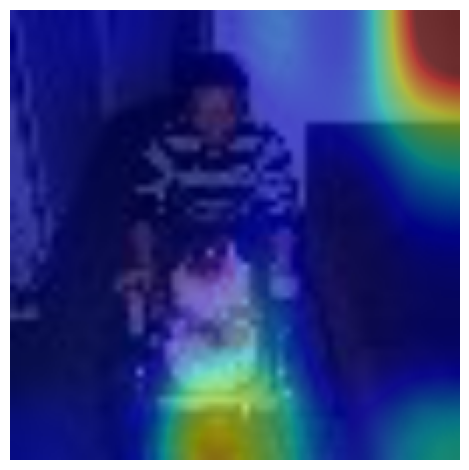

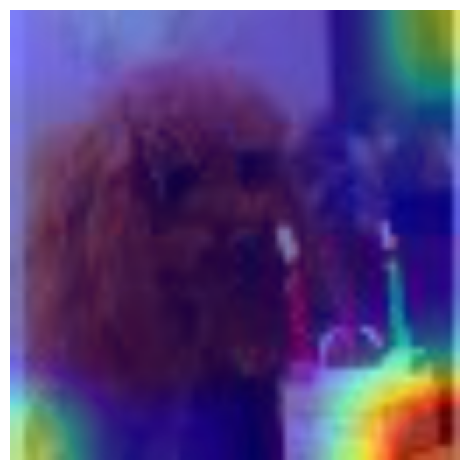

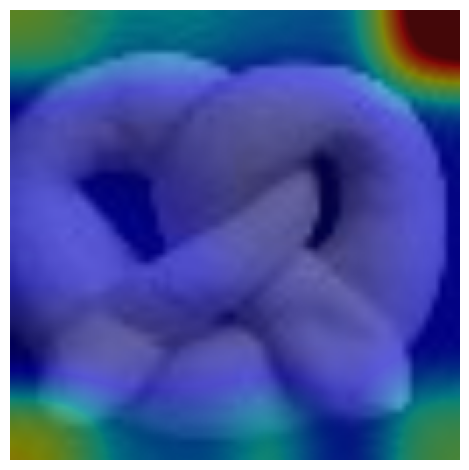

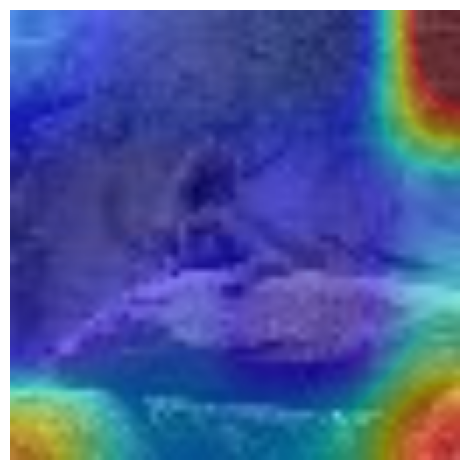

In [91]:
image_paths = ['1ec20470_d3df.JPEG', '04f853fc_2ae3.JPEG', '0688cbd3_6fbf.JPEG', '6e208a7a_25e9.JPEG']

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
])

images = []
for image_path in image_paths:
    img = Image.open('/kaggle/input/test-data/test_set/test_set/' + image_path)
    img = transform(img)
    images.append(img)

alexnet = torchvision.models.alexnet()
features = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(features, 30)
alexnet.to(device)
weights = torch.load('alexnet.pt')
alexnet.load_state_dict(weights)
alexnet.eval()

cam_extractor = SmoothGradCAMpp(model=alexnet, input_shape=(3, 224, 224))

for i in range(len(image_paths)):
    image = images[i].to(device)
    out = alexnet(image.unsqueeze(0))
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
    result = overlay_mask(to_pil_image(image), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
    plt.imshow(result)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

#### 6.3 Your comments on (6 marks):
> a) Why model predictions were correct or incorrect? You can support your case from 6.2

> > The accuracy of a model's predictions depends on how complex the model is, how it was trained, how the data was prepared, and how much noise is in the data. If the model is too simple, it might not capture all the important patterns in the data and make incorrect predictions. If the model is too complex, it might memorize the training data and not be able to make accurate predictions on new data. It is important to choose the right model, prepare the data properly, and use good-quality data to improve prediction accuracy. There are some images where my model is not able to learn the features.

> b) What can you do to improve your results further?

>> The following technique will be used to improve the results

>> Implementing the data augmentation.

>> Improving the model architecture.

>> Fine Tuning.

>> Dropout of unncessary features.

>> HyperParameter Learning


**Please refer to the submission section at the top of this notebook to prepare your submission. Use our teams channel to seek any help!**
